In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
tqdm.pandas()

import huggingface_hub
from datasets import Dataset

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#!pip install huggingface_hub
#!pip install datasets

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Problem Statement

The objective of this notebook is to show various techniques with which to perform a sentiment analysis on a dataset containing film reviews, taken from Ibdm, and then to perform sentiment predictions for unlabelled reviews.
After loading and splitting the data, we will proceed in two directions:

- Tf-Idf word embeddings + Naive Bayes/Xgboost

- Transformer Model fine tuning

In the end, we will evaluate the goodness of the models produced by the two strategies and choose the best one.


In [ ]:
# Import Data
df_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Sentiment_analisys/labeledTrainData.tsv', sep='\t')
df_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Sentiment_analisys/testData.tsv', sep='\t')
df_unlabel = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Sentiment_analisys/unlabeledTrainData.tsv', sep='\t', error_bad_lines=False)

Skipping line 43043: expected 2 fields, saw 3



In [ ]:
df_train.head()

,id,sentiment,review,clean_review
0,5814_8,1,With all this stuff going down at the moment w...,"[stuff, going, moment, listening, music, watch..."
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...","[classic, war, timothy, entertaining, film, ob..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,"[film, manager, bell, giving, welcome, primal,..."
3,3630_4,0,It must be assumed that those who praised this...,"[must, assumed, film, opera, ever, read, somew..."
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,"[superbly, trashy, wondrously, unpretentious, ..."


In [ ]:
print(df_train.shape)
print(df_test.shape)
print(df_unlabel.shape)

(25000, 3)
(25000, 2)
(49998, 2)


In [ ]:
print('Check Assenza Id duplicati')
df_train.id.nunique()==len(df_train)

Check Assenza Id duplicati


True

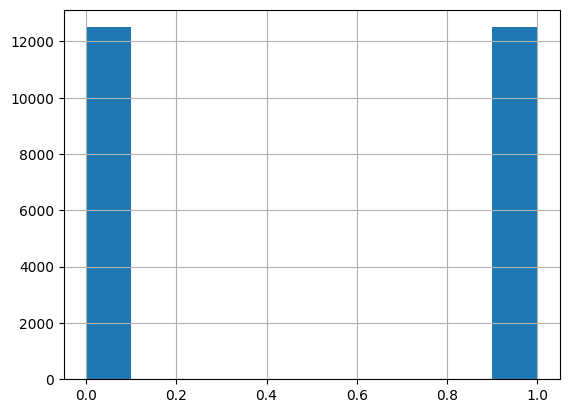

In [ ]:
# Check bilanciamento classi
df_train.sentiment.hist()
plt.show()

## 1) Tf-Idf + Naive Bayse

In this first part we will use the tf-idf technique as word embeddings, in order to derive numerical vectors where each term is associated with an importance score, after which we will use the generated matrix to train two models, Naive Bayes and Xgboost, which according to the literature should be the best performing for this task

### Word Embedding with tf-idf

In [ ]:
# Define some useful elements
lemmatizer = PorterStemmer()
stop_words = set(stopwords.words('english'))
e_words = set(nltk.corpus.words.words())

In [ ]:
# Function to clean the text
def clean_text(text):

    words = word_tokenize(text)
    good_words = []
    for word in words:
        if word.lower() not in stop_words and word.isalpha() and word.lower() in e_words:
            good_words.append(word.lower())
    return good_words

In [ ]:
# Let's apply the function to clear the text
clean_review = df_train['review'].progress_apply(lambda text: clean_text(text))
df_train['clean_review']=clean_review

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
df_train['clean_review'].head()

0    [stuff, going, moment, listening, music, watch...
1    [classic, war, timothy, entertaining, film, ob...
2    [film, manager, bell, giving, welcome, primal,...
3    [must, assumed, film, opera, ever, read, somew...
4    [superbly, trashy, wondrously, unpretentious, ...
Name: clean_review, dtype: object

In [ ]:
df_train.shape

(25000, 4)

In [ ]:
# Create X and Y
Y = df_train['sentiment'].to_list()
X = df_train['clean_review'].apply( lambda x: ' '.join(x))

In [ ]:
X

0        stuff going moment listening music watching od...
1        classic war timothy entertaining film obviousl...
2        film manager bell giving welcome primal park s...
3        must assumed film opera ever read somewhere ei...
4        superbly trashy wondrously unpretentious explo...
                               ...                        
24995    like consideration gone film went review witho...
24996    believe made film completely unnecessary first...
24997    guy loser ca get needs build picked successful...
24998    minute documentary made early one opinion one ...
24999    saw movie child broke heart story unfinished e...
Name: clean_review, Length: 25000, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
X, Y, test_size=0.33, random_state=42)

### Data is prepared, now: tf-idf

In [ ]:
# Let's Define tfidf Vectorizer and create the Matrix with words values
tv = TfidfVectorizer(ngram_range = (2,2), # we choose only bigrams
                    sublinear_tf = True,
                    max_features = 2000)

In [ ]:
# Let's do word embeddings transformation
train_tv = tv.fit_transform(X_train)
train_tv = train_tv.toarray()
print('Train Matrix td-idf: ',train_tv.shape)

val_tv = tv.transform(X_val)
val_tv = val_tv.toarray()
print('Validation Matrix td-idf: ',val_tv.shape)

Train Matrix td-idf:  (16750, 2000)
Validation Matrix td-idf:  (8250, 2000)


### Time to train a ML Model

In [ ]:
# train_tv, y_train
# test_tv, y_val

#### Gaussian Naive Bayes

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

# Build a Gaussian Classifier
nb_classifier = GaussianNB()

# Train the final model on the full training data
nb_classifier.fit(train_tv, y_train)

# Perform cross-validation
cv_scores = cross_val_score(nb_classifier, val_tv, y_val, cv=5)  # You can adjust the number of folds

# Evaluate the model on the test data
test_accuracy = nb_classifier.score(val_tv, y_val)
train_accuracy = nb_classifier.score(train_tv, y_train)

# Print cross-validation scores and test accuracy
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Test Accuracy:", test_accuracy)
print("Train Accuracy:", train_accuracy)


Cross-validation scores: [0.69939394 0.74424242 0.70121212 0.73212121 0.7230303 ]
Mean CV Accuracy: 0.72
Test Accuracy: 0.7487272727272727
Train Accuracy: 0.7870447761194029


In [ ]:
# Make predictions
pred = nb_classifier.predict(val_tv)

# Classification report
target_names = ['class 0', 'class 1']
print(classification_report(y_val, pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.78      0.70      0.73      4105
     class 1       0.73      0.80      0.76      4145

    accuracy                           0.75      8250
   macro avg       0.75      0.75      0.75      8250
weighted avg       0.75      0.75      0.75      8250



In [ ]:
# Possiamo fare predictions su dati che il modello non ha mai visto prima (il nostro test set)
test_tv =  tv.transform(df_test.review)
test_tv = test_tv.toarray()
new_predictions = nb_classifier.predict(test_tv)

In [ ]:
new_predictions # Possiamo usare queste predictions come output finale, in caso decidessimo di usare questa strada

array([1, 0, 1, ..., 1, 1, 0])

#### XGBoost

In [ ]:
# XGBoost (different learning rate)
import xgboost as xgb

learning_rate_range = [ 0.2, 0.3, 0.5, 0.7]

test_XG = []
train_XG = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(train_tv, y_train, eval_set=[(val_tv, y_val)], early_stopping_rounds=10, verbose = False)
    train_XG.append(xgb_classifier.score(train_tv, y_train))
    test_XG.append(xgb_classifier.score(val_tv, y_val))

In [ ]:
# Accuracy with different learning rates
test_XG

[0.7290909090909091, 0.732, 0.7344242424242424, 0.7346666666666667]

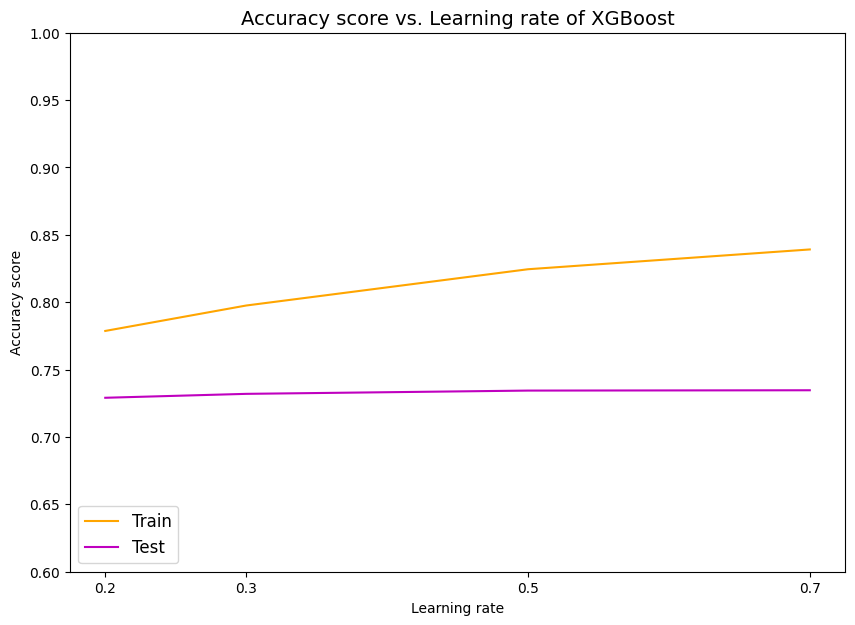

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

# 2) Transformer Model
In this second part, we will use another approach, exploiting the power of transformer models, which represent the state of the art in many NLP-related tasks. Roberta-base' is the model chosen for this task. Its neural network has already been trained for text classification, we will fine-tune its hyper-parameters using our train dataset, so that our model has better predictive performance.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import AutoTokenizer


In [ ]:
#!pip install transformers

In [ ]:
# Importiamo roberta-base model, ottimizzato per task di text classification. Cominciamo dal tokenizer dedicato

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [ ]:
 # Recuperiamo i dati precedentemetne trattati:  X_train, X_val, y_train, y_val

In [ ]:
# Ricreiamo train dataframe utilizzando X e Y
text = pd.Series(X_train, name='text')
text = text.reset_index(drop=True)
labels  = pd.Series(y_train,name='label')
df = pd.concat([text,labels],axis=1)

# Ricreiamo validation dataframe utilizzando X e Y
text_val = pd.Series(X_val, name='text')
text_val = text_val.reset_index(drop=True)
labels_val  = pd.Series(y_val,name='label')
df_v=pd.concat([text_val,labels_val],axis=1)


In [ ]:
df_v.head()

,text,label
0,read girl came peter low period watching movie...,0
1,film attention yeah story opening would given ...,1
2,awful death fire without making character fien...,0
3,saw movie days ago movie great feel want somet...,1
4,film much promise disappointing thinly plotted...,0


In [ ]:
from datasets import Dataset, DatasetDict

# Convertiamo pandas df in hf df, un formato utile in seguito per il fine tuning
dataset_train = Dataset.from_pandas(df)
dataset_validation = Dataset.from_pandas(df_v)

ds = DatasetDict()
ds['train'] = dataset_train
ds['validation'] = dataset_validation

In [ ]:
# Definiamo la funzione per pre-processare i dati testualli attraverso il tokenizer
def preprocess_function(examples):
    output = tokenizer(examples["text"], truncation=True, max_length= 512, padding='max_length')
    return output

In [ ]:
tokenized_train_val = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/16750 [00:00<?, ? examples/s]

Map:   0%|          | 0/8250 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16750
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8250
    })
})

### Fine tuning on our training set

In [ ]:
#! pip install -U accelerate
#! pip install -U transformers

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

In [ ]:

# Carichiamo il modello
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#from transformers import DataCollatorWithPadding
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Definiamo le metriche da seguire durante in train. scegliamo Loss, f1 e Accuracy
from datasets import load_metric
metric = load_metric('accuracy', 'f1')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# It's time to train!

from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Sentiment_analisys/Roberta_model/",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_val['train'],
    eval_dataset=tokenized_train_val['validation'],
    tokenizer=tokenizer,
    #data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)],

)

trainer.train()

# Save model
trainer.save_model('/content/drive/MyDrive/Sentiment_analisys/Roberta_model_all')

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.332300,0.413925,0.842667
2,0.241000,0.306612,0.895636
3,0.191000,0.439359,0.901333
4,0.130300,0.442029,0.899152


TrainOutput(global_step=4188, training_loss=0.23199480971269873, metrics={'train_runtime': 7039.4326, 'train_samples_per_second': 9.518, 'train_steps_per_second': 0.595, 'total_flos': 1.762844070912e+16, 'train_loss': 0.23199480971269873, 'epoch': 4.0})

This model performs significantly better than those previously trained. Therefore, we will proceed to derive predictions from this model, which will be the final output of the required task

### Inference

For reasons of time optimisation, the second half of the df_test was run in another notebook, the same as this one, in parallel, in order to finish in half the time. In the following cells, the second half of the predictions is imported.

In [ ]:
# Dati test - testuali
text = df_test.review.tolist()[12500:]

In [ ]:
from transformers import pipeline, PreTrainedModel, PreTrainedTokenizerFast
import math
from tqdm import tqdm

def convert_and_save(results_ , part):
  # Convert the list to a pandas Series
  data_series = pd.Series(results_)

  # Convert the Series to a pandas DataFrame
  data_df = pd.DataFrame({'Predictions_label': data_series})

  # Save the DataFrame as a CSV file
  data_df.to_csv(f'/content/drive/MyDrive/Colab_Notebooks/Sentiment_analisys/Predictions_{part}.csv', index=False)

  print('ALL DONE')

def process_text_in_batches(texts, batch_size, model, tokenizer):
    # Initialize the sentiment-analysis pipeline
    classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, max_length= 512)

    num_texts = len(texts)
    num_batches = math.ceil(num_texts / batch_size)
    i=0
    predictions = []

    for batch_idx in tqdm(range(num_batches)):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_texts)
        batch = texts[start_idx:end_idx]

        # Process the batch of texts
        batch_predictions = classifier(batch)

        predictions.extend(batch_predictions)
        print('Batch done')
        print('N prediction effettuate: ' +  str(len(predictions)) +'/' + str(num_texts) )

        if batch_idx == int(num_batches/2):
          convert_and_save(predictions, i)
          i=i+1


    return predictions

# Example usage:
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Colab_Notebooks/Sentiment_analisys/Roberta_model_all')
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab_Notebooks/Sentiment_analisys/Roberta_model_all')

batch_size = 16

results = process_text_in_batches(text, batch_size, model, tokenizer)



  0%|          | 1/782 [00:10<2:15:35, 10.42s/it]

Batch done
N prediction effettuate: 16/12500


  0%|          | 2/782 [00:19<2:02:42,  9.44s/it]

Batch done
N prediction effettuate: 32/12500


  0%|          | 3/782 [00:28<2:04:19,  9.58s/it]

Batch done
N prediction effettuate: 48/12500


  1%|          | 4/782 [00:38<2:04:30,  9.60s/it]

Batch done
N prediction effettuate: 64/12500


  1%|          | 5/782 [00:51<2:20:27, 10.85s/it]

Batch done
N prediction effettuate: 80/12500


  1%|          | 6/782 [01:03<2:22:59, 11.06s/it]

Batch done
N prediction effettuate: 96/12500


  1%|          | 7/782 [01:13<2:18:51, 10.75s/it]

Batch done
N prediction effettuate: 112/12500


  1%|          | 8/782 [01:23<2:18:36, 10.75s/it]

Batch done
N prediction effettuate: 128/12500


  1%|          | 9/782 [01:32<2:08:44,  9.99s/it]

Batch done
N prediction effettuate: 144/12500


  1%|▏         | 10/782 [01:40<2:01:27,  9.44s/it]

Batch done
N prediction effettuate: 160/12500


  1%|▏         | 11/782 [01:48<1:57:26,  9.14s/it]

Batch done
N prediction effettuate: 176/12500


  2%|▏         | 12/782 [01:58<2:00:38,  9.40s/it]

Batch done
N prediction effettuate: 192/12500


  2%|▏         | 13/782 [02:07<1:58:53,  9.28s/it]

Batch done
N prediction effettuate: 208/12500


  2%|▏         | 14/782 [02:19<2:06:25,  9.88s/it]

Batch done
N prediction effettuate: 224/12500


  2%|▏         | 15/782 [02:28<2:04:05,  9.71s/it]

Batch done
N prediction effettuate: 240/12500


  2%|▏         | 16/782 [02:38<2:06:57,  9.94s/it]

Batch done
N prediction effettuate: 256/12500


  2%|▏         | 17/782 [02:50<2:13:06, 10.44s/it]

Batch done
N prediction effettuate: 272/12500


  2%|▏         | 18/782 [02:59<2:05:39,  9.87s/it]

Batch done
N prediction effettuate: 288/12500


  2%|▏         | 19/782 [03:10<2:10:13, 10.24s/it]

Batch done
N prediction effettuate: 304/12500


  3%|▎         | 20/782 [03:22<2:17:55, 10.86s/it]

Batch done
N prediction effettuate: 320/12500


  3%|▎         | 21/782 [03:31<2:08:47, 10.15s/it]

Batch done
N prediction effettuate: 336/12500


  3%|▎         | 22/782 [03:42<2:12:11, 10.44s/it]

Batch done
N prediction effettuate: 352/12500


  3%|▎         | 23/782 [03:51<2:06:39, 10.01s/it]

Batch done
N prediction effettuate: 368/12500


  3%|▎         | 24/782 [04:01<2:06:44, 10.03s/it]

Batch done
N prediction effettuate: 384/12500


  3%|▎         | 25/782 [04:11<2:08:36, 10.19s/it]

Batch done
N prediction effettuate: 400/12500


  3%|▎         | 26/782 [04:22<2:08:47, 10.22s/it]

Batch done
N prediction effettuate: 416/12500


  3%|▎         | 27/782 [04:31<2:05:17,  9.96s/it]

Batch done
N prediction effettuate: 432/12500


  4%|▎         | 28/782 [04:39<1:56:56,  9.31s/it]

Batch done
N prediction effettuate: 448/12500


  4%|▎         | 29/782 [04:51<2:07:10, 10.13s/it]

Batch done
N prediction effettuate: 464/12500


  4%|▍         | 30/782 [05:00<2:01:48,  9.72s/it]

Batch done
N prediction effettuate: 480/12500


  4%|▍         | 31/782 [05:09<2:00:12,  9.60s/it]

Batch done
N prediction effettuate: 496/12500


  4%|▍         | 32/782 [05:18<1:59:22,  9.55s/it]

Batch done
N prediction effettuate: 512/12500


  4%|▍         | 33/782 [05:28<1:59:43,  9.59s/it]

Batch done
N prediction effettuate: 528/12500


  4%|▍         | 34/782 [05:41<2:12:38, 10.64s/it]

Batch done
N prediction effettuate: 544/12500


  4%|▍         | 35/782 [05:51<2:10:20, 10.47s/it]

Batch done
N prediction effettuate: 560/12500


  5%|▍         | 36/782 [06:01<2:09:22, 10.41s/it]

Batch done
N prediction effettuate: 576/12500


  5%|▍         | 37/782 [06:14<2:15:50, 10.94s/it]

Batch done
N prediction effettuate: 592/12500


  5%|▍         | 38/782 [06:22<2:06:05, 10.17s/it]

Batch done
N prediction effettuate: 608/12500


  5%|▍         | 39/782 [06:32<2:04:33, 10.06s/it]

Batch done
N prediction effettuate: 624/12500


  5%|▌         | 40/782 [06:41<2:00:03,  9.71s/it]

Batch done
N prediction effettuate: 640/12500


  5%|▌         | 41/782 [06:52<2:06:29, 10.24s/it]

Batch done
N prediction effettuate: 656/12500


  5%|▌         | 42/782 [07:03<2:09:29, 10.50s/it]

Batch done
N prediction effettuate: 672/12500


  5%|▌         | 43/782 [07:11<1:59:55,  9.74s/it]

Batch done
N prediction effettuate: 688/12500


  6%|▌         | 44/782 [07:23<2:05:52, 10.23s/it]

Batch done
N prediction effettuate: 704/12500


  6%|▌         | 45/782 [07:31<1:58:50,  9.67s/it]

Batch done
N prediction effettuate: 720/12500


  6%|▌         | 46/782 [07:41<1:59:39,  9.75s/it]

Batch done
N prediction effettuate: 736/12500


  6%|▌         | 47/782 [07:49<1:51:51,  9.13s/it]

Batch done
N prediction effettuate: 752/12500


  6%|▌         | 48/782 [08:00<2:01:05,  9.90s/it]

Batch done
N prediction effettuate: 768/12500


  6%|▋         | 49/782 [08:10<2:00:38,  9.87s/it]

Batch done
N prediction effettuate: 784/12500


  6%|▋         | 50/782 [08:21<2:02:38, 10.05s/it]

Batch done
N prediction effettuate: 800/12500


  7%|▋         | 51/782 [08:32<2:08:36, 10.56s/it]

Batch done
N prediction effettuate: 816/12500


  7%|▋         | 52/782 [08:43<2:08:12, 10.54s/it]

Batch done
N prediction effettuate: 832/12500


  7%|▋         | 53/782 [08:53<2:06:48, 10.44s/it]

Batch done
N prediction effettuate: 848/12500


  7%|▋         | 54/782 [09:00<1:53:46,  9.38s/it]

Batch done
N prediction effettuate: 864/12500


  7%|▋         | 55/782 [09:12<2:03:35, 10.20s/it]

Batch done
N prediction effettuate: 880/12500


  7%|▋         | 56/782 [09:20<1:54:48,  9.49s/it]

Batch done
N prediction effettuate: 896/12500


  7%|▋         | 57/782 [09:29<1:53:51,  9.42s/it]

Batch done
N prediction effettuate: 912/12500


  7%|▋         | 58/782 [09:40<1:58:02,  9.78s/it]

Batch done
N prediction effettuate: 928/12500


  8%|▊         | 59/782 [09:48<1:52:37,  9.35s/it]

Batch done
N prediction effettuate: 944/12500


  8%|▊         | 60/782 [09:59<1:58:13,  9.82s/it]

Batch done
N prediction effettuate: 960/12500


  8%|▊         | 61/782 [10:08<1:53:54,  9.48s/it]

Batch done
N prediction effettuate: 976/12500


  8%|▊         | 62/782 [10:22<2:12:10, 11.02s/it]

Batch done
N prediction effettuate: 992/12500


  8%|▊         | 63/782 [10:36<2:23:20, 11.96s/it]

Batch done
N prediction effettuate: 1008/12500


  8%|▊         | 64/782 [10:49<2:24:06, 12.04s/it]

Batch done
N prediction effettuate: 1024/12500


  8%|▊         | 65/782 [10:58<2:13:21, 11.16s/it]

Batch done
N prediction effettuate: 1040/12500


  8%|▊         | 66/782 [11:08<2:11:38, 11.03s/it]

Batch done
N prediction effettuate: 1056/12500


  9%|▊         | 67/782 [11:18<2:07:45, 10.72s/it]

Batch done
N prediction effettuate: 1072/12500


  9%|▊         | 68/782 [11:28<2:04:20, 10.45s/it]

Batch done
N prediction effettuate: 1088/12500


  9%|▉         | 69/782 [11:39<2:06:10, 10.62s/it]

Batch done
N prediction effettuate: 1104/12500


  9%|▉         | 70/782 [11:49<2:01:03, 10.20s/it]

Batch done
N prediction effettuate: 1120/12500


  9%|▉         | 71/782 [11:59<2:01:51, 10.28s/it]

Batch done
N prediction effettuate: 1136/12500


  9%|▉         | 72/782 [12:07<1:53:55,  9.63s/it]

Batch done
N prediction effettuate: 1152/12500


  9%|▉         | 73/782 [12:17<1:56:02,  9.82s/it]

Batch done
N prediction effettuate: 1168/12500


  9%|▉         | 74/782 [12:29<2:00:40, 10.23s/it]

Batch done
N prediction effettuate: 1184/12500


 10%|▉         | 75/782 [12:36<1:52:04,  9.51s/it]

Batch done
N prediction effettuate: 1200/12500


 10%|▉         | 76/782 [12:50<2:05:30, 10.67s/it]

Batch done
N prediction effettuate: 1216/12500


 10%|▉         | 77/782 [12:57<1:53:46,  9.68s/it]

Batch done
N prediction effettuate: 1232/12500


 10%|▉         | 78/782 [13:09<2:00:30, 10.27s/it]

Batch done
N prediction effettuate: 1248/12500


 10%|█         | 79/782 [13:18<1:56:38,  9.96s/it]

Batch done
N prediction effettuate: 1264/12500


 10%|█         | 80/782 [13:29<1:58:54, 10.16s/it]

Batch done
N prediction effettuate: 1280/12500


 10%|█         | 81/782 [13:41<2:05:11, 10.72s/it]

Batch done
N prediction effettuate: 1296/12500


 10%|█         | 82/782 [13:50<1:59:56, 10.28s/it]

Batch done
N prediction effettuate: 1312/12500


 11%|█         | 83/782 [14:01<2:02:38, 10.53s/it]

Batch done
N prediction effettuate: 1328/12500


 11%|█         | 84/782 [14:09<1:55:07,  9.90s/it]

Batch done
N prediction effettuate: 1344/12500


 11%|█         | 85/782 [14:18<1:49:46,  9.45s/it]

Batch done
N prediction effettuate: 1360/12500


 11%|█         | 86/782 [14:29<1:54:24,  9.86s/it]

Batch done
N prediction effettuate: 1376/12500


 11%|█         | 87/782 [14:38<1:53:39,  9.81s/it]

Batch done
N prediction effettuate: 1392/12500


 11%|█▏        | 88/782 [14:49<1:54:57,  9.94s/it]

Batch done
N prediction effettuate: 1408/12500


 11%|█▏        | 89/782 [14:58<1:54:21,  9.90s/it]

Batch done
N prediction effettuate: 1424/12500


 12%|█▏        | 90/782 [15:10<1:59:17, 10.34s/it]

Batch done
N prediction effettuate: 1440/12500


 12%|█▏        | 91/782 [15:19<1:55:27, 10.03s/it]

Batch done
N prediction effettuate: 1456/12500


 12%|█▏        | 92/782 [15:30<1:56:56, 10.17s/it]

Batch done
N prediction effettuate: 1472/12500


 12%|█▏        | 93/782 [15:39<1:55:00, 10.01s/it]

Batch done
N prediction effettuate: 1488/12500


 12%|█▏        | 94/782 [15:48<1:52:11,  9.78s/it]

Batch done
N prediction effettuate: 1504/12500


 12%|█▏        | 95/782 [15:59<1:54:50, 10.03s/it]

Batch done
N prediction effettuate: 1520/12500


 12%|█▏        | 96/782 [16:07<1:48:33,  9.49s/it]

Batch done
N prediction effettuate: 1536/12500


 12%|█▏        | 97/782 [16:19<1:54:13, 10.01s/it]

Batch done
N prediction effettuate: 1552/12500


 13%|█▎        | 98/782 [16:27<1:49:06,  9.57s/it]

Batch done
N prediction effettuate: 1568/12500


 13%|█▎        | 99/782 [16:37<1:51:41,  9.81s/it]

Batch done
N prediction effettuate: 1584/12500


 13%|█▎        | 100/782 [16:50<2:00:49, 10.63s/it]

Batch done
N prediction effettuate: 1600/12500


 13%|█▎        | 101/782 [16:59<1:55:43, 10.20s/it]

Batch done
N prediction effettuate: 1616/12500


 13%|█▎        | 102/782 [17:12<2:04:25, 10.98s/it]

Batch done
N prediction effettuate: 1632/12500


 13%|█▎        | 103/782 [17:21<1:55:56, 10.24s/it]

Batch done
N prediction effettuate: 1648/12500


 13%|█▎        | 104/782 [17:30<1:52:16,  9.94s/it]

Batch done
N prediction effettuate: 1664/12500


 13%|█▎        | 105/782 [17:40<1:54:05, 10.11s/it]

Batch done
N prediction effettuate: 1680/12500


 14%|█▎        | 106/782 [17:52<2:00:00, 10.65s/it]

Batch done
N prediction effettuate: 1696/12500


 14%|█▎        | 107/782 [18:05<2:05:31, 11.16s/it]

Batch done
N prediction effettuate: 1712/12500


 14%|█▍        | 108/782 [18:16<2:07:49, 11.38s/it]

Batch done
N prediction effettuate: 1728/12500


 14%|█▍        | 109/782 [18:26<2:01:09, 10.80s/it]

Batch done
N prediction effettuate: 1744/12500


 14%|█▍        | 110/782 [18:34<1:53:33, 10.14s/it]

Batch done
N prediction effettuate: 1760/12500


 14%|█▍        | 111/782 [18:42<1:44:16,  9.32s/it]

Batch done
N prediction effettuate: 1776/12500


 14%|█▍        | 112/782 [18:52<1:46:42,  9.56s/it]

Batch done
N prediction effettuate: 1792/12500


 14%|█▍        | 113/782 [19:01<1:44:10,  9.34s/it]

Batch done
N prediction effettuate: 1808/12500


 15%|█▍        | 114/782 [19:11<1:47:40,  9.67s/it]

Batch done
N prediction effettuate: 1824/12500


 15%|█▍        | 115/782 [19:20<1:45:28,  9.49s/it]

Batch done
N prediction effettuate: 1840/12500


 15%|█▍        | 116/782 [19:29<1:41:10,  9.12s/it]

Batch done
N prediction effettuate: 1856/12500


 15%|█▍        | 117/782 [19:40<1:47:43,  9.72s/it]

Batch done
N prediction effettuate: 1872/12500


 15%|█▌        | 118/782 [19:50<1:48:28,  9.80s/it]

Batch done
N prediction effettuate: 1888/12500


 15%|█▌        | 119/782 [19:58<1:44:54,  9.49s/it]

Batch done
N prediction effettuate: 1904/12500


 15%|█▌        | 120/782 [20:06<1:38:27,  8.92s/it]

Batch done
N prediction effettuate: 1920/12500


 15%|█▌        | 121/782 [20:19<1:50:45, 10.05s/it]

Batch done
N prediction effettuate: 1936/12500


 16%|█▌        | 122/782 [20:29<1:50:58, 10.09s/it]

Batch done
N prediction effettuate: 1952/12500


 16%|█▌        | 123/782 [20:40<1:52:57, 10.28s/it]

Batch done
N prediction effettuate: 1968/12500


 16%|█▌        | 124/782 [20:49<1:51:16, 10.15s/it]

Batch done
N prediction effettuate: 1984/12500


 16%|█▌        | 125/782 [21:00<1:53:26, 10.36s/it]

Batch done
N prediction effettuate: 2000/12500


 16%|█▌        | 126/782 [21:12<1:58:16, 10.82s/it]

Batch done
N prediction effettuate: 2016/12500


 16%|█▌        | 127/782 [21:24<2:00:52, 11.07s/it]

Batch done
N prediction effettuate: 2032/12500


 16%|█▋        | 128/782 [21:32<1:50:59, 10.18s/it]

Batch done
N prediction effettuate: 2048/12500


 16%|█▋        | 129/782 [21:42<1:51:37, 10.26s/it]

Batch done
N prediction effettuate: 2064/12500


 17%|█▋        | 130/782 [21:52<1:49:26, 10.07s/it]

Batch done
N prediction effettuate: 2080/12500


 17%|█▋        | 131/782 [22:02<1:48:14,  9.98s/it]

Batch done
N prediction effettuate: 2096/12500


 17%|█▋        | 132/782 [22:15<1:56:53, 10.79s/it]

Batch done
N prediction effettuate: 2112/12500


 17%|█▋        | 133/782 [22:25<1:54:38, 10.60s/it]

Batch done
N prediction effettuate: 2128/12500


 17%|█▋        | 134/782 [22:36<1:58:12, 10.95s/it]

Batch done
N prediction effettuate: 2144/12500


 17%|█▋        | 135/782 [22:47<1:55:34, 10.72s/it]

Batch done
N prediction effettuate: 2160/12500


 17%|█▋        | 136/782 [22:55<1:49:09, 10.14s/it]

Batch done
N prediction effettuate: 2176/12500


 18%|█▊        | 137/782 [23:05<1:45:45,  9.84s/it]

Batch done
N prediction effettuate: 2192/12500


 18%|█▊        | 138/782 [23:13<1:42:18,  9.53s/it]

Batch done
N prediction effettuate: 2208/12500


 18%|█▊        | 139/782 [23:24<1:46:27,  9.93s/it]

Batch done
N prediction effettuate: 2224/12500


 18%|█▊        | 140/782 [23:34<1:46:09,  9.92s/it]

Batch done
N prediction effettuate: 2240/12500


 18%|█▊        | 141/782 [23:45<1:50:39, 10.36s/it]

Batch done
N prediction effettuate: 2256/12500


 18%|█▊        | 142/782 [23:56<1:49:46, 10.29s/it]

Batch done
N prediction effettuate: 2272/12500


 18%|█▊        | 143/782 [24:04<1:44:31,  9.82s/it]

Batch done
N prediction effettuate: 2288/12500


 18%|█▊        | 144/782 [24:14<1:43:02,  9.69s/it]

Batch done
N prediction effettuate: 2304/12500


 19%|█▊        | 145/782 [24:23<1:41:36,  9.57s/it]

Batch done
N prediction effettuate: 2320/12500


 19%|█▊        | 146/782 [24:34<1:45:47,  9.98s/it]

Batch done
N prediction effettuate: 2336/12500


 19%|█▉        | 147/782 [24:42<1:38:22,  9.30s/it]

Batch done
N prediction effettuate: 2352/12500


 19%|█▉        | 148/782 [24:51<1:36:46,  9.16s/it]

Batch done
N prediction effettuate: 2368/12500


 19%|█▉        | 149/782 [25:00<1:36:46,  9.17s/it]

Batch done
N prediction effettuate: 2384/12500


 19%|█▉        | 150/782 [25:12<1:47:35, 10.21s/it]

Batch done
N prediction effettuate: 2400/12500


 19%|█▉        | 151/782 [25:21<1:43:38,  9.85s/it]

Batch done
N prediction effettuate: 2416/12500


 19%|█▉        | 152/782 [25:31<1:41:31,  9.67s/it]

Batch done
N prediction effettuate: 2432/12500


 20%|█▉        | 153/782 [25:41<1:42:30,  9.78s/it]

Batch done
N prediction effettuate: 2448/12500


 20%|█▉        | 154/782 [25:48<1:35:03,  9.08s/it]

Batch done
N prediction effettuate: 2464/12500


 20%|█▉        | 155/782 [25:56<1:31:59,  8.80s/it]

Batch done
N prediction effettuate: 2480/12500


 20%|█▉        | 156/782 [26:07<1:39:05,  9.50s/it]

Batch done
N prediction effettuate: 2496/12500


 20%|██        | 157/782 [26:18<1:42:17,  9.82s/it]

Batch done
N prediction effettuate: 2512/12500


 20%|██        | 158/782 [26:27<1:40:26,  9.66s/it]

Batch done
N prediction effettuate: 2528/12500


 20%|██        | 159/782 [26:37<1:40:57,  9.72s/it]

Batch done
N prediction effettuate: 2544/12500


 20%|██        | 160/782 [26:46<1:39:28,  9.60s/it]

Batch done
N prediction effettuate: 2560/12500


 21%|██        | 161/782 [26:54<1:33:17,  9.01s/it]

Batch done
N prediction effettuate: 2576/12500


 21%|██        | 162/782 [27:02<1:31:12,  8.83s/it]

Batch done
N prediction effettuate: 2592/12500


 21%|██        | 163/782 [27:15<1:42:10,  9.90s/it]

Batch done
N prediction effettuate: 2608/12500


 21%|██        | 164/782 [27:29<1:54:56, 11.16s/it]

Batch done
N prediction effettuate: 2624/12500


 21%|██        | 165/782 [27:39<1:50:30, 10.75s/it]

Batch done
N prediction effettuate: 2640/12500


 21%|██        | 166/782 [27:49<1:47:34, 10.48s/it]

Batch done
N prediction effettuate: 2656/12500


 21%|██▏       | 167/782 [27:58<1:45:40, 10.31s/it]

Batch done
N prediction effettuate: 2672/12500


 21%|██▏       | 168/782 [28:09<1:45:20, 10.29s/it]

Batch done
N prediction effettuate: 2688/12500


 22%|██▏       | 169/782 [28:19<1:44:02, 10.18s/it]

Batch done
N prediction effettuate: 2704/12500


 22%|██▏       | 170/782 [28:27<1:39:37,  9.77s/it]

Batch done
N prediction effettuate: 2720/12500


 22%|██▏       | 171/782 [28:37<1:37:11,  9.54s/it]

Batch done
N prediction effettuate: 2736/12500


 22%|██▏       | 172/782 [28:47<1:40:26,  9.88s/it]

Batch done
N prediction effettuate: 2752/12500


 22%|██▏       | 173/782 [28:57<1:39:42,  9.82s/it]

Batch done
N prediction effettuate: 2768/12500


 22%|██▏       | 174/782 [29:09<1:45:15, 10.39s/it]

Batch done
N prediction effettuate: 2784/12500


 22%|██▏       | 175/782 [29:17<1:38:28,  9.73s/it]

Batch done
N prediction effettuate: 2800/12500


 23%|██▎       | 176/782 [29:28<1:41:37, 10.06s/it]

Batch done
N prediction effettuate: 2816/12500


 23%|██▎       | 177/782 [29:36<1:35:15,  9.45s/it]

Batch done
N prediction effettuate: 2832/12500


 23%|██▎       | 178/782 [29:47<1:41:51, 10.12s/it]

Batch done
N prediction effettuate: 2848/12500


 23%|██▎       | 179/782 [29:56<1:37:02,  9.66s/it]

Batch done
N prediction effettuate: 2864/12500


 23%|██▎       | 180/782 [30:05<1:34:24,  9.41s/it]

Batch done
N prediction effettuate: 2880/12500


 23%|██▎       | 181/782 [30:11<1:24:00,  8.39s/it]

Batch done
N prediction effettuate: 2896/12500


 23%|██▎       | 182/782 [30:22<1:31:49,  9.18s/it]

Batch done
N prediction effettuate: 2912/12500


 23%|██▎       | 183/782 [30:32<1:34:18,  9.45s/it]

Batch done
N prediction effettuate: 2928/12500


 24%|██▎       | 184/782 [30:41<1:34:43,  9.50s/it]

Batch done
N prediction effettuate: 2944/12500


 24%|██▎       | 185/782 [30:52<1:36:35,  9.71s/it]

Batch done
N prediction effettuate: 2960/12500


 24%|██▍       | 186/782 [31:01<1:34:11,  9.48s/it]

Batch done
N prediction effettuate: 2976/12500


 24%|██▍       | 187/782 [31:10<1:33:17,  9.41s/it]

Batch done
N prediction effettuate: 2992/12500


 24%|██▍       | 188/782 [31:18<1:29:14,  9.01s/it]

Batch done
N prediction effettuate: 3008/12500


 24%|██▍       | 189/782 [31:29<1:36:19,  9.75s/it]

Batch done
N prediction effettuate: 3024/12500


 24%|██▍       | 190/782 [31:39<1:36:58,  9.83s/it]

Batch done
N prediction effettuate: 3040/12500


 24%|██▍       | 191/782 [31:50<1:40:03, 10.16s/it]

Batch done
N prediction effettuate: 3056/12500


 25%|██▍       | 192/782 [32:00<1:39:47, 10.15s/it]

Batch done
N prediction effettuate: 3072/12500


 25%|██▍       | 193/782 [32:09<1:35:56,  9.77s/it]

Batch done
N prediction effettuate: 3088/12500


 25%|██▍       | 194/782 [32:20<1:36:56,  9.89s/it]

Batch done
N prediction effettuate: 3104/12500


 25%|██▍       | 195/782 [32:29<1:35:18,  9.74s/it]

Batch done
N prediction effettuate: 3120/12500


 25%|██▌       | 196/782 [32:42<1:45:38, 10.82s/it]

Batch done
N prediction effettuate: 3136/12500


 25%|██▌       | 197/782 [32:53<1:45:17, 10.80s/it]

Batch done
N prediction effettuate: 3152/12500


 25%|██▌       | 198/782 [33:01<1:35:41,  9.83s/it]

Batch done
N prediction effettuate: 3168/12500


 25%|██▌       | 199/782 [33:12<1:41:18, 10.43s/it]

Batch done
N prediction effettuate: 3184/12500


 26%|██▌       | 200/782 [33:21<1:34:58,  9.79s/it]

Batch done
N prediction effettuate: 3200/12500


 26%|██▌       | 201/782 [33:32<1:38:19, 10.15s/it]

Batch done
N prediction effettuate: 3216/12500


 26%|██▌       | 202/782 [33:40<1:33:15,  9.65s/it]

Batch done
N prediction effettuate: 3232/12500


 26%|██▌       | 203/782 [33:50<1:33:03,  9.64s/it]

Batch done
N prediction effettuate: 3248/12500


 26%|██▌       | 204/782 [33:58<1:27:38,  9.10s/it]

Batch done
N prediction effettuate: 3264/12500


 26%|██▌       | 205/782 [34:08<1:30:52,  9.45s/it]

Batch done
N prediction effettuate: 3280/12500


 26%|██▋       | 206/782 [34:21<1:39:55, 10.41s/it]

Batch done
N prediction effettuate: 3296/12500


 26%|██▋       | 207/782 [34:30<1:36:35, 10.08s/it]

Batch done
N prediction effettuate: 3312/12500


 27%|██▋       | 208/782 [34:40<1:36:13, 10.06s/it]

Batch done
N prediction effettuate: 3328/12500


 27%|██▋       | 209/782 [34:47<1:28:58,  9.32s/it]

Batch done
N prediction effettuate: 3344/12500


 27%|██▋       | 210/782 [34:57<1:29:22,  9.38s/it]

Batch done
N prediction effettuate: 3360/12500


 27%|██▋       | 211/782 [35:07<1:30:33,  9.52s/it]

Batch done
N prediction effettuate: 3376/12500


 27%|██▋       | 212/782 [35:18<1:35:10, 10.02s/it]

Batch done
N prediction effettuate: 3392/12500


 27%|██▋       | 213/782 [35:30<1:40:46, 10.63s/it]

Batch done
N prediction effettuate: 3408/12500


 27%|██▋       | 214/782 [35:38<1:32:59,  9.82s/it]

Batch done
N prediction effettuate: 3424/12500


 27%|██▋       | 215/782 [35:49<1:35:01, 10.06s/it]

Batch done
N prediction effettuate: 3440/12500


 28%|██▊       | 216/782 [36:00<1:38:21, 10.43s/it]

Batch done
N prediction effettuate: 3456/12500


 28%|██▊       | 217/782 [36:10<1:36:10, 10.21s/it]

Batch done
N prediction effettuate: 3472/12500


 28%|██▊       | 218/782 [36:19<1:34:29, 10.05s/it]

Batch done
N prediction effettuate: 3488/12500


 28%|██▊       | 219/782 [36:28<1:29:59,  9.59s/it]

Batch done
N prediction effettuate: 3504/12500


 28%|██▊       | 220/782 [36:37<1:29:32,  9.56s/it]

Batch done
N prediction effettuate: 3520/12500


 28%|██▊       | 221/782 [36:45<1:23:04,  8.89s/it]

Batch done
N prediction effettuate: 3536/12500


 28%|██▊       | 222/782 [36:54<1:25:51,  9.20s/it]

Batch done
N prediction effettuate: 3552/12500


 29%|██▊       | 223/782 [37:02<1:20:00,  8.59s/it]

Batch done
N prediction effettuate: 3568/12500


 29%|██▊       | 224/782 [37:13<1:26:36,  9.31s/it]

Batch done
N prediction effettuate: 3584/12500


 29%|██▉       | 225/782 [37:26<1:38:52, 10.65s/it]

Batch done
N prediction effettuate: 3600/12500


 29%|██▉       | 226/782 [37:33<1:26:28,  9.33s/it]

Batch done
N prediction effettuate: 3616/12500


 29%|██▉       | 227/782 [37:43<1:29:14,  9.65s/it]

Batch done
N prediction effettuate: 3632/12500


 29%|██▉       | 228/782 [37:52<1:27:27,  9.47s/it]

Batch done
N prediction effettuate: 3648/12500


 29%|██▉       | 229/782 [38:01<1:26:18,  9.36s/it]

Batch done
N prediction effettuate: 3664/12500


 29%|██▉       | 230/782 [38:11<1:27:45,  9.54s/it]

Batch done
N prediction effettuate: 3680/12500


 30%|██▉       | 231/782 [38:21<1:28:37,  9.65s/it]

Batch done
N prediction effettuate: 3696/12500


 30%|██▉       | 232/782 [38:30<1:26:20,  9.42s/it]

Batch done
N prediction effettuate: 3712/12500


 30%|██▉       | 233/782 [38:40<1:28:34,  9.68s/it]

Batch done
N prediction effettuate: 3728/12500


 30%|██▉       | 234/782 [38:48<1:23:57,  9.19s/it]

Batch done
N prediction effettuate: 3744/12500


 30%|███       | 235/782 [38:58<1:24:31,  9.27s/it]

Batch done
N prediction effettuate: 3760/12500


 30%|███       | 236/782 [39:06<1:20:34,  8.85s/it]

Batch done
N prediction effettuate: 3776/12500


 30%|███       | 237/782 [39:15<1:22:16,  9.06s/it]

Batch done
N prediction effettuate: 3792/12500


 30%|███       | 238/782 [39:22<1:16:42,  8.46s/it]

Batch done
N prediction effettuate: 3808/12500


 31%|███       | 239/782 [39:32<1:18:42,  8.70s/it]

Batch done
N prediction effettuate: 3824/12500


 31%|███       | 240/782 [39:39<1:14:52,  8.29s/it]

Batch done
N prediction effettuate: 3840/12500


 31%|███       | 241/782 [39:49<1:20:05,  8.88s/it]

Batch done
N prediction effettuate: 3856/12500


 31%|███       | 242/782 [39:57<1:17:48,  8.65s/it]

Batch done
N prediction effettuate: 3872/12500


 31%|███       | 243/782 [40:07<1:20:21,  8.95s/it]

Batch done
N prediction effettuate: 3888/12500


 31%|███       | 244/782 [40:17<1:24:29,  9.42s/it]

Batch done
N prediction effettuate: 3904/12500


 31%|███▏      | 245/782 [40:27<1:25:54,  9.60s/it]

Batch done
N prediction effettuate: 3920/12500


 31%|███▏      | 246/782 [40:38<1:28:23,  9.89s/it]

Batch done
N prediction effettuate: 3936/12500


 32%|███▏      | 247/782 [40:47<1:25:27,  9.58s/it]

Batch done
N prediction effettuate: 3952/12500


 32%|███▏      | 248/782 [40:57<1:26:10,  9.68s/it]

Batch done
N prediction effettuate: 3968/12500


 32%|███▏      | 249/782 [41:08<1:30:37, 10.20s/it]

Batch done
N prediction effettuate: 3984/12500


 32%|███▏      | 250/782 [41:19<1:32:15, 10.40s/it]

Batch done
N prediction effettuate: 4000/12500


 32%|███▏      | 251/782 [41:31<1:36:33, 10.91s/it]

Batch done
N prediction effettuate: 4016/12500


 32%|███▏      | 252/782 [41:38<1:26:03,  9.74s/it]

Batch done
N prediction effettuate: 4032/12500


 32%|███▏      | 253/782 [41:50<1:32:09, 10.45s/it]

Batch done
N prediction effettuate: 4048/12500


 32%|███▏      | 254/782 [41:58<1:24:49,  9.64s/it]

Batch done
N prediction effettuate: 4064/12500


 33%|███▎      | 255/782 [42:07<1:22:21,  9.38s/it]

Batch done
N prediction effettuate: 4080/12500


 33%|███▎      | 256/782 [42:17<1:23:11,  9.49s/it]

Batch done
N prediction effettuate: 4096/12500


 33%|███▎      | 257/782 [42:26<1:23:43,  9.57s/it]

Batch done
N prediction effettuate: 4112/12500


 33%|███▎      | 258/782 [42:39<1:31:02, 10.42s/it]

Batch done
N prediction effettuate: 4128/12500


 33%|███▎      | 259/782 [42:47<1:26:26,  9.92s/it]

Batch done
N prediction effettuate: 4144/12500


 33%|███▎      | 260/782 [42:59<1:30:41, 10.42s/it]

Batch done
N prediction effettuate: 4160/12500


 33%|███▎      | 261/782 [43:09<1:28:14, 10.16s/it]

Batch done
N prediction effettuate: 4176/12500


 34%|███▎      | 262/782 [43:18<1:26:59, 10.04s/it]

Batch done
N prediction effettuate: 4192/12500


 34%|███▎      | 263/782 [43:31<1:33:57, 10.86s/it]

Batch done
N prediction effettuate: 4208/12500


 34%|███▍      | 264/782 [43:44<1:39:36, 11.54s/it]

Batch done
N prediction effettuate: 4224/12500


 34%|███▍      | 265/782 [43:54<1:35:07, 11.04s/it]

Batch done
N prediction effettuate: 4240/12500


 34%|███▍      | 266/782 [44:04<1:32:00, 10.70s/it]

Batch done
N prediction effettuate: 4256/12500


 34%|███▍      | 267/782 [44:13<1:27:31, 10.20s/it]

Batch done
N prediction effettuate: 4272/12500


 34%|███▍      | 268/782 [44:26<1:34:02, 10.98s/it]

Batch done
N prediction effettuate: 4288/12500


 34%|███▍      | 269/782 [44:37<1:33:10, 10.90s/it]

Batch done
N prediction effettuate: 4304/12500


 35%|███▍      | 270/782 [44:44<1:24:35,  9.91s/it]

Batch done
N prediction effettuate: 4320/12500


 35%|███▍      | 271/782 [44:53<1:20:54,  9.50s/it]

Batch done
N prediction effettuate: 4336/12500


 35%|███▍      | 272/782 [45:02<1:20:04,  9.42s/it]

Batch done
N prediction effettuate: 4352/12500


 35%|███▍      | 273/782 [45:13<1:23:28,  9.84s/it]

Batch done
N prediction effettuate: 4368/12500


 35%|███▌      | 274/782 [45:22<1:21:55,  9.68s/it]

Batch done
N prediction effettuate: 4384/12500


 35%|███▌      | 275/782 [45:33<1:24:04,  9.95s/it]

Batch done
N prediction effettuate: 4400/12500


 35%|███▌      | 276/782 [45:42<1:22:41,  9.81s/it]

Batch done
N prediction effettuate: 4416/12500


 35%|███▌      | 277/782 [45:53<1:25:42, 10.18s/it]

Batch done
N prediction effettuate: 4432/12500


 36%|███▌      | 278/782 [46:04<1:27:37, 10.43s/it]

Batch done
N prediction effettuate: 4448/12500


 36%|███▌      | 279/782 [46:13<1:23:18,  9.94s/it]

Batch done
N prediction effettuate: 4464/12500


 36%|███▌      | 280/782 [46:22<1:19:47,  9.54s/it]

Batch done
N prediction effettuate: 4480/12500


 36%|███▌      | 281/782 [46:31<1:18:55,  9.45s/it]

Batch done
N prediction effettuate: 4496/12500


 36%|███▌      | 282/782 [46:43<1:24:37, 10.15s/it]

Batch done
N prediction effettuate: 4512/12500


 36%|███▌      | 283/782 [46:53<1:25:30, 10.28s/it]

Batch done
N prediction effettuate: 4528/12500


 36%|███▋      | 284/782 [47:02<1:21:52,  9.86s/it]

Batch done
N prediction effettuate: 4544/12500


 36%|███▋      | 285/782 [47:13<1:24:39, 10.22s/it]

Batch done
N prediction effettuate: 4560/12500


 37%|███▋      | 286/782 [47:21<1:18:18,  9.47s/it]

Batch done
N prediction effettuate: 4576/12500


 37%|███▋      | 287/782 [47:31<1:20:14,  9.73s/it]

Batch done
N prediction effettuate: 4592/12500


 37%|███▋      | 288/782 [47:42<1:23:02, 10.09s/it]

Batch done
N prediction effettuate: 4608/12500


 37%|███▋      | 289/782 [47:52<1:21:54,  9.97s/it]

Batch done
N prediction effettuate: 4624/12500


 37%|███▋      | 290/782 [48:00<1:18:26,  9.57s/it]

Batch done
N prediction effettuate: 4640/12500


 37%|███▋      | 291/782 [48:10<1:19:02,  9.66s/it]

Batch done
N prediction effettuate: 4656/12500


 37%|███▋      | 292/782 [48:21<1:20:15,  9.83s/it]

Batch done
N prediction effettuate: 4672/12500


 37%|███▋      | 293/782 [48:30<1:18:37,  9.65s/it]

Batch done
N prediction effettuate: 4688/12500


 38%|███▊      | 294/782 [48:40<1:20:51,  9.94s/it]

Batch done
N prediction effettuate: 4704/12500


 38%|███▊      | 295/782 [48:49<1:17:46,  9.58s/it]

Batch done
N prediction effettuate: 4720/12500


 38%|███▊      | 296/782 [49:00<1:20:23,  9.93s/it]

Batch done
N prediction effettuate: 4736/12500


 38%|███▊      | 297/782 [49:08<1:15:10,  9.30s/it]

Batch done
N prediction effettuate: 4752/12500


 38%|███▊      | 298/782 [49:18<1:17:41,  9.63s/it]

Batch done
N prediction effettuate: 4768/12500


 38%|███▊      | 299/782 [49:26<1:12:59,  9.07s/it]

Batch done
N prediction effettuate: 4784/12500


 38%|███▊      | 300/782 [49:34<1:11:32,  8.91s/it]

Batch done
N prediction effettuate: 4800/12500


 38%|███▊      | 301/782 [49:42<1:08:21,  8.53s/it]

Batch done
N prediction effettuate: 4816/12500


 39%|███▊      | 302/782 [49:53<1:15:15,  9.41s/it]

Batch done
N prediction effettuate: 4832/12500


 39%|███▊      | 303/782 [50:05<1:21:02, 10.15s/it]

Batch done
N prediction effettuate: 4848/12500


 39%|███▉      | 304/782 [50:15<1:19:57, 10.04s/it]

Batch done
N prediction effettuate: 4864/12500


 39%|███▉      | 305/782 [50:24<1:16:15,  9.59s/it]

Batch done
N prediction effettuate: 4880/12500


 39%|███▉      | 306/782 [50:32<1:11:50,  9.06s/it]

Batch done
N prediction effettuate: 4896/12500


 39%|███▉      | 307/782 [50:42<1:14:09,  9.37s/it]

Batch done
N prediction effettuate: 4912/12500


 39%|███▉      | 308/782 [50:50<1:11:01,  8.99s/it]

Batch done
N prediction effettuate: 4928/12500


 40%|███▉      | 309/782 [51:01<1:15:26,  9.57s/it]

Batch done
N prediction effettuate: 4944/12500


 40%|███▉      | 310/782 [51:11<1:16:47,  9.76s/it]

Batch done
N prediction effettuate: 4960/12500


 40%|███▉      | 311/782 [51:21<1:17:20,  9.85s/it]

Batch done
N prediction effettuate: 4976/12500


 40%|███▉      | 312/782 [51:32<1:19:57, 10.21s/it]

Batch done
N prediction effettuate: 4992/12500


 40%|████      | 313/782 [51:44<1:23:27, 10.68s/it]

Batch done
N prediction effettuate: 5008/12500


 40%|████      | 314/782 [51:53<1:20:40, 10.34s/it]

Batch done
N prediction effettuate: 5024/12500


 40%|████      | 315/782 [52:02<1:16:30,  9.83s/it]

Batch done
N prediction effettuate: 5040/12500


 40%|████      | 316/782 [52:12<1:16:23,  9.84s/it]

Batch done
N prediction effettuate: 5056/12500


 41%|████      | 317/782 [52:19<1:10:25,  9.09s/it]

Batch done
N prediction effettuate: 5072/12500


 41%|████      | 318/782 [52:28<1:10:19,  9.09s/it]

Batch done
N prediction effettuate: 5088/12500


 41%|████      | 319/782 [52:41<1:18:57, 10.23s/it]

Batch done
N prediction effettuate: 5104/12500


 41%|████      | 320/782 [52:51<1:19:10, 10.28s/it]

Batch done
N prediction effettuate: 5120/12500


 41%|████      | 321/782 [53:02<1:18:59, 10.28s/it]

Batch done
N prediction effettuate: 5136/12500


 41%|████      | 322/782 [53:14<1:22:45, 10.79s/it]

Batch done
N prediction effettuate: 5152/12500


 41%|████▏     | 323/782 [53:21<1:14:46,  9.77s/it]

Batch done
N prediction effettuate: 5168/12500


 41%|████▏     | 324/782 [53:33<1:19:15, 10.38s/it]

Batch done
N prediction effettuate: 5184/12500


 42%|████▏     | 325/782 [53:40<1:12:16,  9.49s/it]

Batch done
N prediction effettuate: 5200/12500


 42%|████▏     | 326/782 [53:51<1:15:30,  9.94s/it]

Batch done
N prediction effettuate: 5216/12500


 42%|████▏     | 327/782 [54:03<1:18:29, 10.35s/it]

Batch done
N prediction effettuate: 5232/12500


 42%|████▏     | 328/782 [54:10<1:12:23,  9.57s/it]

Batch done
N prediction effettuate: 5248/12500


 42%|████▏     | 329/782 [54:20<1:12:30,  9.60s/it]

Batch done
N prediction effettuate: 5264/12500


 42%|████▏     | 330/782 [54:30<1:13:49,  9.80s/it]

Batch done
N prediction effettuate: 5280/12500


 42%|████▏     | 331/782 [54:42<1:18:04, 10.39s/it]

Batch done
N prediction effettuate: 5296/12500


 42%|████▏     | 332/782 [54:52<1:16:27, 10.20s/it]

Batch done
N prediction effettuate: 5312/12500


 43%|████▎     | 333/782 [55:00<1:12:36,  9.70s/it]

Batch done
N prediction effettuate: 5328/12500


 43%|████▎     | 334/782 [55:14<1:20:36, 10.80s/it]

Batch done
N prediction effettuate: 5344/12500


 43%|████▎     | 335/782 [55:22<1:15:08, 10.09s/it]

Batch done
N prediction effettuate: 5360/12500


 43%|████▎     | 336/782 [55:33<1:16:36, 10.31s/it]

Batch done
N prediction effettuate: 5376/12500


 43%|████▎     | 337/782 [55:43<1:16:44, 10.35s/it]

Batch done
N prediction effettuate: 5392/12500


 43%|████▎     | 338/782 [55:52<1:13:32,  9.94s/it]

Batch done
N prediction effettuate: 5408/12500


 43%|████▎     | 339/782 [56:03<1:14:10, 10.05s/it]

Batch done
N prediction effettuate: 5424/12500


 43%|████▎     | 340/782 [56:12<1:12:57,  9.90s/it]

Batch done
N prediction effettuate: 5440/12500


 44%|████▎     | 341/782 [56:22<1:12:16,  9.83s/it]

Batch done
N prediction effettuate: 5456/12500


 44%|████▎     | 342/782 [56:29<1:06:50,  9.11s/it]

Batch done
N prediction effettuate: 5472/12500


 44%|████▍     | 343/782 [56:40<1:10:02,  9.57s/it]

Batch done
N prediction effettuate: 5488/12500


 44%|████▍     | 344/782 [56:48<1:06:17,  9.08s/it]

Batch done
N prediction effettuate: 5504/12500


 44%|████▍     | 345/782 [56:58<1:08:17,  9.38s/it]

Batch done
N prediction effettuate: 5520/12500


 44%|████▍     | 346/782 [57:06<1:05:44,  9.05s/it]

Batch done
N prediction effettuate: 5536/12500


 44%|████▍     | 347/782 [57:16<1:05:56,  9.10s/it]

Batch done
N prediction effettuate: 5552/12500


 45%|████▍     | 348/782 [57:25<1:06:18,  9.17s/it]

Batch done
N prediction effettuate: 5568/12500


 45%|████▍     | 349/782 [57:36<1:10:50,  9.82s/it]

Batch done
N prediction effettuate: 5584/12500


 45%|████▍     | 350/782 [57:48<1:15:04, 10.43s/it]

Batch done
N prediction effettuate: 5600/12500


 45%|████▍     | 351/782 [57:57<1:11:01,  9.89s/it]

Batch done
N prediction effettuate: 5616/12500


 45%|████▌     | 352/782 [58:07<1:11:34,  9.99s/it]

Batch done
N prediction effettuate: 5632/12500


 45%|████▌     | 353/782 [58:15<1:08:22,  9.56s/it]

Batch done
N prediction effettuate: 5648/12500


 45%|████▌     | 354/782 [58:26<1:11:05,  9.97s/it]

Batch done
N prediction effettuate: 5664/12500


 45%|████▌     | 355/782 [58:35<1:08:39,  9.65s/it]

Batch done
N prediction effettuate: 5680/12500


 46%|████▌     | 356/782 [58:47<1:12:25, 10.20s/it]

Batch done
N prediction effettuate: 5696/12500


 46%|████▌     | 357/782 [58:57<1:12:16, 10.20s/it]

Batch done
N prediction effettuate: 5712/12500


 46%|████▌     | 358/782 [59:05<1:07:59,  9.62s/it]

Batch done
N prediction effettuate: 5728/12500


 46%|████▌     | 359/782 [59:17<1:11:25, 10.13s/it]

Batch done
N prediction effettuate: 5744/12500


 46%|████▌     | 360/782 [59:26<1:10:37, 10.04s/it]

Batch done
N prediction effettuate: 5760/12500


 46%|████▌     | 361/782 [59:36<1:09:51,  9.96s/it]

Batch done
N prediction effettuate: 5776/12500


 46%|████▋     | 362/782 [59:46<1:09:50,  9.98s/it]

Batch done
N prediction effettuate: 5792/12500


 46%|████▋     | 363/782 [59:55<1:06:26,  9.51s/it]

Batch done
N prediction effettuate: 5808/12500


 47%|████▋     | 364/782 [1:00:05<1:08:26,  9.82s/it]

Batch done
N prediction effettuate: 5824/12500


 47%|████▋     | 365/782 [1:00:14<1:05:30,  9.43s/it]

Batch done
N prediction effettuate: 5840/12500


 47%|████▋     | 366/782 [1:00:25<1:08:24,  9.87s/it]

Batch done
N prediction effettuate: 5856/12500


 47%|████▋     | 367/782 [1:00:33<1:04:58,  9.39s/it]

Batch done
N prediction effettuate: 5872/12500


 47%|████▋     | 368/782 [1:00:42<1:04:40,  9.37s/it]

Batch done
N prediction effettuate: 5888/12500


 47%|████▋     | 369/782 [1:00:51<1:02:57,  9.15s/it]

Batch done
N prediction effettuate: 5904/12500


 47%|████▋     | 370/782 [1:01:01<1:05:38,  9.56s/it]

Batch done
N prediction effettuate: 5920/12500


 47%|████▋     | 371/782 [1:01:10<1:03:30,  9.27s/it]

Batch done
N prediction effettuate: 5936/12500


 48%|████▊     | 372/782 [1:01:17<58:46,  8.60s/it]  

Batch done
N prediction effettuate: 5952/12500


 48%|████▊     | 373/782 [1:01:22<51:59,  7.63s/it]

Batch done
N prediction effettuate: 5968/12500


 48%|████▊     | 374/782 [1:01:33<58:26,  8.60s/it]

Batch done
N prediction effettuate: 5984/12500


 48%|████▊     | 375/782 [1:01:42<59:09,  8.72s/it]

Batch done
N prediction effettuate: 6000/12500


 48%|████▊     | 376/782 [1:01:52<1:02:08,  9.18s/it]

Batch done
N prediction effettuate: 6016/12500


 48%|████▊     | 377/782 [1:02:02<1:02:16,  9.23s/it]

Batch done
N prediction effettuate: 6032/12500


 48%|████▊     | 378/782 [1:02:11<1:01:26,  9.13s/it]

Batch done
N prediction effettuate: 6048/12500


 48%|████▊     | 379/782 [1:02:21<1:04:44,  9.64s/it]

Batch done
N prediction effettuate: 6064/12500


 49%|████▊     | 380/782 [1:02:31<1:04:04,  9.56s/it]

Batch done
N prediction effettuate: 6080/12500


 49%|████▊     | 381/782 [1:02:41<1:04:14,  9.61s/it]

Batch done
N prediction effettuate: 6096/12500


 49%|████▉     | 382/782 [1:02:50<1:03:15,  9.49s/it]

Batch done
N prediction effettuate: 6112/12500


 49%|████▉     | 383/782 [1:03:01<1:06:07,  9.94s/it]

Batch done
N prediction effettuate: 6128/12500


 49%|████▉     | 384/782 [1:03:10<1:05:26,  9.87s/it]

Batch done
N prediction effettuate: 6144/12500


 49%|████▉     | 385/782 [1:03:22<1:07:56, 10.27s/it]

Batch done
N prediction effettuate: 6160/12500


 49%|████▉     | 386/782 [1:03:32<1:08:30, 10.38s/it]

Batch done
N prediction effettuate: 6176/12500


 49%|████▉     | 387/782 [1:03:40<1:03:01,  9.57s/it]

Batch done
N prediction effettuate: 6192/12500


 50%|████▉     | 388/782 [1:03:51<1:05:42, 10.01s/it]

Batch done
N prediction effettuate: 6208/12500


 50%|████▉     | 389/782 [1:03:59<1:00:45,  9.28s/it]

Batch done
N prediction effettuate: 6224/12500


 50%|████▉     | 390/782 [1:04:10<1:05:37, 10.04s/it]

Batch done
N prediction effettuate: 6240/12500


 50%|█████     | 391/782 [1:04:20<1:04:29,  9.90s/it]

Batch done
N prediction effettuate: 6256/12500


 50%|█████     | 392/782 [1:04:28<1:00:14,  9.27s/it]

Batch done
N prediction effettuate: 6272/12500
ALL DONE


 50%|█████     | 393/782 [1:04:35<56:51,  8.77s/it]  

Batch done
N prediction effettuate: 6288/12500


 50%|█████     | 394/782 [1:04:44<57:05,  8.83s/it]

Batch done
N prediction effettuate: 6304/12500


 51%|█████     | 395/782 [1:04:53<56:27,  8.75s/it]

Batch done
N prediction effettuate: 6320/12500


 51%|█████     | 396/782 [1:05:01<54:41,  8.50s/it]

Batch done
N prediction effettuate: 6336/12500


 51%|█████     | 397/782 [1:05:11<58:26,  9.11s/it]

Batch done
N prediction effettuate: 6352/12500


 51%|█████     | 398/782 [1:05:22<1:00:23,  9.44s/it]

Batch done
N prediction effettuate: 6368/12500


 51%|█████     | 399/782 [1:05:33<1:04:06, 10.04s/it]

Batch done
N prediction effettuate: 6384/12500


 51%|█████     | 400/782 [1:05:41<59:35,  9.36s/it]  

Batch done
N prediction effettuate: 6400/12500


 51%|█████▏    | 401/782 [1:05:53<1:05:11, 10.27s/it]

Batch done
N prediction effettuate: 6416/12500


 51%|█████▏    | 402/782 [1:06:03<1:03:47, 10.07s/it]

Batch done
N prediction effettuate: 6432/12500


 52%|█████▏    | 403/782 [1:06:11<59:50,  9.47s/it]  

Batch done
N prediction effettuate: 6448/12500


 52%|█████▏    | 404/782 [1:06:23<1:03:42, 10.11s/it]

Batch done
N prediction effettuate: 6464/12500


 52%|█████▏    | 405/782 [1:06:33<1:04:12, 10.22s/it]

Batch done
N prediction effettuate: 6480/12500


 52%|█████▏    | 406/782 [1:06:45<1:06:53, 10.67s/it]

Batch done
N prediction effettuate: 6496/12500


 52%|█████▏    | 407/782 [1:06:53<1:02:05,  9.94s/it]

Batch done
N prediction effettuate: 6512/12500


 52%|█████▏    | 408/782 [1:07:03<1:02:21, 10.00s/it]

Batch done
N prediction effettuate: 6528/12500


 52%|█████▏    | 409/782 [1:07:16<1:07:06, 10.80s/it]

Batch done
N prediction effettuate: 6544/12500


 52%|█████▏    | 410/782 [1:07:28<1:09:08, 11.15s/it]

Batch done
N prediction effettuate: 6560/12500


 53%|█████▎    | 411/782 [1:07:39<1:09:54, 11.31s/it]

Batch done
N prediction effettuate: 6576/12500


 53%|█████▎    | 412/782 [1:07:48<1:05:10, 10.57s/it]

Batch done
N prediction effettuate: 6592/12500


 53%|█████▎    | 413/782 [1:07:57<1:01:00,  9.92s/it]

Batch done
N prediction effettuate: 6608/12500


 53%|█████▎    | 414/782 [1:08:05<58:47,  9.59s/it]  

Batch done
N prediction effettuate: 6624/12500


 53%|█████▎    | 415/782 [1:08:14<56:31,  9.24s/it]

Batch done
N prediction effettuate: 6640/12500


 53%|█████▎    | 416/782 [1:08:23<55:45,  9.14s/it]

Batch done
N prediction effettuate: 6656/12500


 53%|█████▎    | 417/782 [1:08:32<55:59,  9.20s/it]

Batch done
N prediction effettuate: 6672/12500


 53%|█████▎    | 418/782 [1:08:43<58:09,  9.59s/it]

Batch done
N prediction effettuate: 6688/12500


 54%|█████▎    | 419/782 [1:08:49<51:40,  8.54s/it]

Batch done
N prediction effettuate: 6704/12500


 54%|█████▎    | 420/782 [1:09:00<56:37,  9.38s/it]

Batch done
N prediction effettuate: 6720/12500


 54%|█████▍    | 421/782 [1:09:10<57:15,  9.52s/it]

Batch done
N prediction effettuate: 6736/12500


 54%|█████▍    | 422/782 [1:09:23<1:02:49, 10.47s/it]

Batch done
N prediction effettuate: 6752/12500


 54%|█████▍    | 423/782 [1:09:33<1:03:11, 10.56s/it]

Batch done
N prediction effettuate: 6768/12500


 54%|█████▍    | 424/782 [1:09:42<59:31,  9.98s/it]  

Batch done
N prediction effettuate: 6784/12500


 54%|█████▍    | 425/782 [1:09:55<1:05:26, 11.00s/it]

Batch done
N prediction effettuate: 6800/12500


 54%|█████▍    | 426/782 [1:10:04<1:01:23, 10.35s/it]

Batch done
N prediction effettuate: 6816/12500


 55%|█████▍    | 427/782 [1:10:13<58:26,  9.88s/it]  

Batch done
N prediction effettuate: 6832/12500


 55%|█████▍    | 428/782 [1:10:22<55:58,  9.49s/it]

Batch done
N prediction effettuate: 6848/12500


 55%|█████▍    | 429/782 [1:10:31<55:30,  9.44s/it]

Batch done
N prediction effettuate: 6864/12500


 55%|█████▍    | 430/782 [1:10:42<58:52, 10.04s/it]

Batch done
N prediction effettuate: 6880/12500


 55%|█████▌    | 431/782 [1:10:48<51:55,  8.87s/it]

Batch done
N prediction effettuate: 6896/12500


 55%|█████▌    | 432/782 [1:10:59<54:05,  9.27s/it]

Batch done
N prediction effettuate: 6912/12500


 55%|█████▌    | 433/782 [1:11:06<51:06,  8.79s/it]

Batch done
N prediction effettuate: 6928/12500


 55%|█████▌    | 434/782 [1:11:17<54:24,  9.38s/it]

Batch done
N prediction effettuate: 6944/12500


 56%|█████▌    | 435/782 [1:11:27<54:22,  9.40s/it]

Batch done
N prediction effettuate: 6960/12500


 56%|█████▌    | 436/782 [1:11:39<59:15, 10.28s/it]

Batch done
N prediction effettuate: 6976/12500


 56%|█████▌    | 437/782 [1:11:48<57:24,  9.98s/it]

Batch done
N prediction effettuate: 6992/12500


 56%|█████▌    | 438/782 [1:11:59<59:30, 10.38s/it]

Batch done
N prediction effettuate: 7008/12500


 56%|█████▌    | 439/782 [1:12:11<1:01:18, 10.72s/it]

Batch done
N prediction effettuate: 7024/12500


 56%|█████▋    | 440/782 [1:12:23<1:03:27, 11.13s/it]

Batch done
N prediction effettuate: 7040/12500


 56%|█████▋    | 441/782 [1:12:33<1:00:32, 10.65s/it]

Batch done
N prediction effettuate: 7056/12500


 57%|█████▋    | 442/782 [1:12:43<1:00:17, 10.64s/it]

Batch done
N prediction effettuate: 7072/12500


 57%|█████▋    | 443/782 [1:12:52<56:21,  9.98s/it]  

Batch done
N prediction effettuate: 7088/12500


 57%|█████▋    | 444/782 [1:13:02<57:40, 10.24s/it]

Batch done
N prediction effettuate: 7104/12500


 57%|█████▋    | 445/782 [1:13:10<52:36,  9.37s/it]

Batch done
N prediction effettuate: 7120/12500


 57%|█████▋    | 446/782 [1:13:20<53:51,  9.62s/it]

Batch done
N prediction effettuate: 7136/12500


 57%|█████▋    | 447/782 [1:13:28<50:13,  9.00s/it]

Batch done
N prediction effettuate: 7152/12500


 57%|█████▋    | 448/782 [1:13:38<52:58,  9.52s/it]

Batch done
N prediction effettuate: 7168/12500


 57%|█████▋    | 449/782 [1:13:49<54:41,  9.85s/it]

Batch done
N prediction effettuate: 7184/12500


 58%|█████▊    | 450/782 [1:13:58<53:06,  9.60s/it]

Batch done
N prediction effettuate: 7200/12500


 58%|█████▊    | 451/782 [1:14:07<51:23,  9.32s/it]

Batch done
N prediction effettuate: 7216/12500


 58%|█████▊    | 452/782 [1:14:16<51:09,  9.30s/it]

Batch done
N prediction effettuate: 7232/12500


 58%|█████▊    | 453/782 [1:14:26<51:40,  9.42s/it]

Batch done
N prediction effettuate: 7248/12500


 58%|█████▊    | 454/782 [1:14:35<51:52,  9.49s/it]

Batch done
N prediction effettuate: 7264/12500


 58%|█████▊    | 455/782 [1:14:46<54:11,  9.94s/it]

Batch done
N prediction effettuate: 7280/12500


 58%|█████▊    | 456/782 [1:14:55<52:23,  9.64s/it]

Batch done
N prediction effettuate: 7296/12500


 58%|█████▊    | 457/782 [1:15:05<52:11,  9.63s/it]

Batch done
N prediction effettuate: 7312/12500


 59%|█████▊    | 458/782 [1:15:14<51:15,  9.49s/it]

Batch done
N prediction effettuate: 7328/12500


 59%|█████▊    | 459/782 [1:15:24<51:15,  9.52s/it]

Batch done
N prediction effettuate: 7344/12500


 59%|█████▉    | 460/782 [1:15:37<57:48, 10.77s/it]

Batch done
N prediction effettuate: 7360/12500


 59%|█████▉    | 461/782 [1:15:46<54:29, 10.19s/it]

Batch done
N prediction effettuate: 7376/12500


 59%|█████▉    | 462/782 [1:15:58<57:48, 10.84s/it]

Batch done
N prediction effettuate: 7392/12500


 59%|█████▉    | 463/782 [1:16:10<58:21, 10.98s/it]

Batch done
N prediction effettuate: 7408/12500


 59%|█████▉    | 464/782 [1:16:18<53:31, 10.10s/it]

Batch done
N prediction effettuate: 7424/12500


 59%|█████▉    | 465/782 [1:16:27<52:30,  9.94s/it]

Batch done
N prediction effettuate: 7440/12500


 60%|█████▉    | 466/782 [1:16:36<50:58,  9.68s/it]

Batch done
N prediction effettuate: 7456/12500


 60%|█████▉    | 467/782 [1:16:47<52:23,  9.98s/it]

Batch done
N prediction effettuate: 7472/12500


 60%|█████▉    | 468/782 [1:16:55<49:30,  9.46s/it]

Batch done
N prediction effettuate: 7488/12500


 60%|█████▉    | 469/782 [1:17:04<47:49,  9.17s/it]

Batch done
N prediction effettuate: 7504/12500


 60%|██████    | 470/782 [1:17:14<49:11,  9.46s/it]

Batch done
N prediction effettuate: 7520/12500


 60%|██████    | 471/782 [1:17:22<46:33,  8.98s/it]

Batch done
N prediction effettuate: 7536/12500


 60%|██████    | 472/782 [1:17:33<49:33,  9.59s/it]

Batch done
N prediction effettuate: 7552/12500


 60%|██████    | 473/782 [1:17:41<47:31,  9.23s/it]

Batch done
N prediction effettuate: 7568/12500


 61%|██████    | 474/782 [1:17:51<48:48,  9.51s/it]

Batch done
N prediction effettuate: 7584/12500


 61%|██████    | 475/782 [1:18:01<48:16,  9.43s/it]

Batch done
N prediction effettuate: 7600/12500


 61%|██████    | 476/782 [1:18:11<48:49,  9.57s/it]

Batch done
N prediction effettuate: 7616/12500


 61%|██████    | 477/782 [1:18:17<43:53,  8.63s/it]

Batch done
N prediction effettuate: 7632/12500


 61%|██████    | 478/782 [1:18:29<48:47,  9.63s/it]

Batch done
N prediction effettuate: 7648/12500


 61%|██████▏   | 479/782 [1:18:36<45:15,  8.96s/it]

Batch done
N prediction effettuate: 7664/12500


 61%|██████▏   | 480/782 [1:18:47<47:46,  9.49s/it]

Batch done
N prediction effettuate: 7680/12500


 62%|██████▏   | 481/782 [1:18:57<47:51,  9.54s/it]

Batch done
N prediction effettuate: 7696/12500


 62%|██████▏   | 482/782 [1:19:07<48:26,  9.69s/it]

Batch done
N prediction effettuate: 7712/12500


 62%|██████▏   | 483/782 [1:19:18<50:55, 10.22s/it]

Batch done
N prediction effettuate: 7728/12500


 62%|██████▏   | 484/782 [1:19:25<45:23,  9.14s/it]

Batch done
N prediction effettuate: 7744/12500


 62%|██████▏   | 485/782 [1:19:34<45:44,  9.24s/it]

Batch done
N prediction effettuate: 7760/12500


 62%|██████▏   | 486/782 [1:19:42<43:19,  8.78s/it]

Batch done
N prediction effettuate: 7776/12500


 62%|██████▏   | 487/782 [1:19:52<45:34,  9.27s/it]

Batch done
N prediction effettuate: 7792/12500


 62%|██████▏   | 488/782 [1:20:03<47:54,  9.78s/it]

Batch done
N prediction effettuate: 7808/12500


 63%|██████▎   | 489/782 [1:20:12<46:10,  9.45s/it]

Batch done
N prediction effettuate: 7824/12500


 63%|██████▎   | 490/782 [1:20:20<44:14,  9.09s/it]

Batch done
N prediction effettuate: 7840/12500


 63%|██████▎   | 491/782 [1:20:31<46:23,  9.56s/it]

Batch done
N prediction effettuate: 7856/12500


 63%|██████▎   | 492/782 [1:20:39<43:39,  9.03s/it]

Batch done
N prediction effettuate: 7872/12500


 63%|██████▎   | 493/782 [1:20:49<44:49,  9.31s/it]

Batch done
N prediction effettuate: 7888/12500


 63%|██████▎   | 494/782 [1:20:58<44:10,  9.20s/it]

Batch done
N prediction effettuate: 7904/12500


 63%|██████▎   | 495/782 [1:21:09<47:04,  9.84s/it]

Batch done
N prediction effettuate: 7920/12500


 63%|██████▎   | 496/782 [1:21:19<47:48, 10.03s/it]

Batch done
N prediction effettuate: 7936/12500


 64%|██████▎   | 497/782 [1:21:30<47:58, 10.10s/it]

Batch done
N prediction effettuate: 7952/12500


 64%|██████▎   | 498/782 [1:21:39<46:13,  9.76s/it]

Batch done
N prediction effettuate: 7968/12500


 64%|██████▍   | 499/782 [1:21:51<50:02, 10.61s/it]

Batch done
N prediction effettuate: 7984/12500


 64%|██████▍   | 500/782 [1:22:00<47:09, 10.03s/it]

Batch done
N prediction effettuate: 8000/12500


 64%|██████▍   | 501/782 [1:22:12<49:44, 10.62s/it]

Batch done
N prediction effettuate: 8016/12500


 64%|██████▍   | 502/782 [1:22:22<48:30, 10.39s/it]

Batch done
N prediction effettuate: 8032/12500


 64%|██████▍   | 503/782 [1:22:31<47:15, 10.16s/it]

Batch done
N prediction effettuate: 8048/12500


 64%|██████▍   | 504/782 [1:22:39<42:54,  9.26s/it]

Batch done
N prediction effettuate: 8064/12500


 65%|██████▍   | 505/782 [1:22:49<44:46,  9.70s/it]

Batch done
N prediction effettuate: 8080/12500


 65%|██████▍   | 506/782 [1:22:59<43:59,  9.56s/it]

Batch done
N prediction effettuate: 8096/12500


 65%|██████▍   | 507/782 [1:23:07<42:24,  9.25s/it]

Batch done
N prediction effettuate: 8112/12500


 65%|██████▍   | 508/782 [1:23:17<43:12,  9.46s/it]

Batch done
N prediction effettuate: 8128/12500


 65%|██████▌   | 509/782 [1:23:28<45:29, 10.00s/it]

Batch done
N prediction effettuate: 8144/12500


 65%|██████▌   | 510/782 [1:23:37<43:08,  9.52s/it]

Batch done
N prediction effettuate: 8160/12500


 65%|██████▌   | 511/782 [1:23:46<42:59,  9.52s/it]

Batch done
N prediction effettuate: 8176/12500


 65%|██████▌   | 512/782 [1:23:56<43:27,  9.66s/it]

Batch done
N prediction effettuate: 8192/12500


 66%|██████▌   | 513/782 [1:24:10<48:58, 10.92s/it]

Batch done
N prediction effettuate: 8208/12500


 66%|██████▌   | 514/782 [1:24:19<45:40, 10.23s/it]

Batch done
N prediction effettuate: 8224/12500


 66%|██████▌   | 515/782 [1:24:31<47:40, 10.71s/it]

Batch done
N prediction effettuate: 8240/12500


 66%|██████▌   | 516/782 [1:24:41<47:38, 10.75s/it]

Batch done
N prediction effettuate: 8256/12500


 66%|██████▌   | 517/782 [1:24:52<46:49, 10.60s/it]

Batch done
N prediction effettuate: 8272/12500


 66%|██████▌   | 518/782 [1:25:02<45:44, 10.40s/it]

Batch done
N prediction effettuate: 8288/12500


 66%|██████▋   | 519/782 [1:25:09<41:03,  9.37s/it]

Batch done
N prediction effettuate: 8304/12500


 66%|██████▋   | 520/782 [1:25:18<40:22,  9.25s/it]

Batch done
N prediction effettuate: 8320/12500


 67%|██████▋   | 521/782 [1:25:25<38:15,  8.80s/it]

Batch done
N prediction effettuate: 8336/12500


 67%|██████▋   | 522/782 [1:25:38<43:04,  9.94s/it]

Batch done
N prediction effettuate: 8352/12500


 67%|██████▋   | 523/782 [1:25:50<46:23, 10.75s/it]

Batch done
N prediction effettuate: 8368/12500


 67%|██████▋   | 524/782 [1:26:00<44:19, 10.31s/it]

Batch done
N prediction effettuate: 8384/12500


 67%|██████▋   | 525/782 [1:26:11<45:18, 10.58s/it]

Batch done
N prediction effettuate: 8400/12500


 67%|██████▋   | 526/782 [1:26:18<40:59,  9.61s/it]

Batch done
N prediction effettuate: 8416/12500


 67%|██████▋   | 527/782 [1:26:30<42:54, 10.10s/it]

Batch done
N prediction effettuate: 8432/12500


 68%|██████▊   | 528/782 [1:26:39<41:22,  9.77s/it]

Batch done
N prediction effettuate: 8448/12500


 68%|██████▊   | 529/782 [1:26:49<41:57,  9.95s/it]

Batch done
N prediction effettuate: 8464/12500


 68%|██████▊   | 530/782 [1:26:59<41:42,  9.93s/it]

Batch done
N prediction effettuate: 8480/12500


 68%|██████▊   | 531/782 [1:27:09<42:07, 10.07s/it]

Batch done
N prediction effettuate: 8496/12500


 68%|██████▊   | 532/782 [1:27:22<44:47, 10.75s/it]

Batch done
N prediction effettuate: 8512/12500


 68%|██████▊   | 533/782 [1:27:32<44:18, 10.67s/it]

Batch done
N prediction effettuate: 8528/12500


 68%|██████▊   | 534/782 [1:27:43<44:39, 10.80s/it]

Batch done
N prediction effettuate: 8544/12500


 68%|██████▊   | 535/782 [1:27:54<44:12, 10.74s/it]

Batch done
N prediction effettuate: 8560/12500


 69%|██████▊   | 536/782 [1:28:04<43:13, 10.54s/it]

Batch done
N prediction effettuate: 8576/12500


 69%|██████▊   | 537/782 [1:28:16<44:40, 10.94s/it]

Batch done
N prediction effettuate: 8592/12500


 69%|██████▉   | 538/782 [1:28:27<44:51, 11.03s/it]

Batch done
N prediction effettuate: 8608/12500


 69%|██████▉   | 539/782 [1:28:34<39:14,  9.69s/it]

Batch done
N prediction effettuate: 8624/12500


 69%|██████▉   | 540/782 [1:28:45<41:23, 10.26s/it]

Batch done
N prediction effettuate: 8640/12500


 69%|██████▉   | 541/782 [1:28:54<39:07,  9.74s/it]

Batch done
N prediction effettuate: 8656/12500


 69%|██████▉   | 542/782 [1:29:02<36:56,  9.24s/it]

Batch done
N prediction effettuate: 8672/12500


 69%|██████▉   | 543/782 [1:29:11<37:28,  9.41s/it]

Batch done
N prediction effettuate: 8688/12500


 70%|██████▉   | 544/782 [1:29:21<37:32,  9.46s/it]

Batch done
N prediction effettuate: 8704/12500


 70%|██████▉   | 545/782 [1:29:29<35:21,  8.95s/it]

Batch done
N prediction effettuate: 8720/12500


 70%|██████▉   | 546/782 [1:29:41<38:25,  9.77s/it]

Batch done
N prediction effettuate: 8736/12500


 70%|██████▉   | 547/782 [1:29:53<41:05, 10.49s/it]

Batch done
N prediction effettuate: 8752/12500


 70%|███████   | 548/782 [1:30:05<42:36, 10.93s/it]

Batch done
N prediction effettuate: 8768/12500


 70%|███████   | 549/782 [1:30:13<39:08, 10.08s/it]

Batch done
N prediction effettuate: 8784/12500


 70%|███████   | 550/782 [1:30:23<38:58, 10.08s/it]

Batch done
N prediction effettuate: 8800/12500


 70%|███████   | 551/782 [1:30:34<39:42, 10.31s/it]

Batch done
N prediction effettuate: 8816/12500


 71%|███████   | 552/782 [1:30:45<41:11, 10.75s/it]

Batch done
N prediction effettuate: 8832/12500


 71%|███████   | 553/782 [1:30:56<41:22, 10.84s/it]

Batch done
N prediction effettuate: 8848/12500


 71%|███████   | 554/782 [1:31:05<38:58, 10.26s/it]

Batch done
N prediction effettuate: 8864/12500


 71%|███████   | 555/782 [1:31:15<37:55, 10.02s/it]

Batch done
N prediction effettuate: 8880/12500


 71%|███████   | 556/782 [1:31:24<37:10,  9.87s/it]

Batch done
N prediction effettuate: 8896/12500


 71%|███████   | 557/782 [1:31:35<37:37, 10.03s/it]

Batch done
N prediction effettuate: 8912/12500


 71%|███████▏  | 558/782 [1:31:47<40:17, 10.79s/it]

Batch done
N prediction effettuate: 8928/12500


 71%|███████▏  | 559/782 [1:31:59<40:45, 10.97s/it]

Batch done
N prediction effettuate: 8944/12500


 72%|███████▏  | 560/782 [1:32:11<41:50, 11.31s/it]

Batch done
N prediction effettuate: 8960/12500


 72%|███████▏  | 561/782 [1:32:19<37:56, 10.30s/it]

Batch done
N prediction effettuate: 8976/12500


 72%|███████▏  | 562/782 [1:32:29<37:25, 10.21s/it]

Batch done
N prediction effettuate: 8992/12500


 72%|███████▏  | 563/782 [1:32:37<35:22,  9.69s/it]

Batch done
N prediction effettuate: 9008/12500


 72%|███████▏  | 564/782 [1:32:46<33:47,  9.30s/it]

Batch done
N prediction effettuate: 9024/12500


 72%|███████▏  | 565/782 [1:32:54<32:23,  8.95s/it]

Batch done
N prediction effettuate: 9040/12500


 72%|███████▏  | 566/782 [1:33:05<34:36,  9.62s/it]

Batch done
N prediction effettuate: 9056/12500


 73%|███████▎  | 567/782 [1:33:17<36:47, 10.27s/it]

Batch done
N prediction effettuate: 9072/12500


 73%|███████▎  | 568/782 [1:33:27<36:44, 10.30s/it]

Batch done
N prediction effettuate: 9088/12500


 73%|███████▎  | 569/782 [1:33:39<37:53, 10.68s/it]

Batch done
N prediction effettuate: 9104/12500


 73%|███████▎  | 570/782 [1:33:49<37:42, 10.67s/it]

Batch done
N prediction effettuate: 9120/12500


 73%|███████▎  | 571/782 [1:33:59<36:07, 10.27s/it]

Batch done
N prediction effettuate: 9136/12500


 73%|███████▎  | 572/782 [1:34:11<37:38, 10.75s/it]

Batch done
N prediction effettuate: 9152/12500


 73%|███████▎  | 573/782 [1:34:20<35:48, 10.28s/it]

Batch done
N prediction effettuate: 9168/12500


 73%|███████▎  | 574/782 [1:34:31<37:01, 10.68s/it]

Batch done
N prediction effettuate: 9184/12500


 74%|███████▎  | 575/782 [1:34:40<34:42, 10.06s/it]

Batch done
N prediction effettuate: 9200/12500


 74%|███████▎  | 576/782 [1:34:49<33:23,  9.73s/it]

Batch done
N prediction effettuate: 9216/12500


 74%|███████▍  | 577/782 [1:34:59<34:00,  9.95s/it]

Batch done
N prediction effettuate: 9232/12500


 74%|███████▍  | 578/782 [1:35:09<33:42,  9.91s/it]

Batch done
N prediction effettuate: 9248/12500


 74%|███████▍  | 579/782 [1:35:20<34:48, 10.29s/it]

Batch done
N prediction effettuate: 9264/12500


 74%|███████▍  | 580/782 [1:35:30<34:01, 10.11s/it]

Batch done
N prediction effettuate: 9280/12500


 74%|███████▍  | 581/782 [1:35:38<31:42,  9.47s/it]

Batch done
N prediction effettuate: 9296/12500


 74%|███████▍  | 582/782 [1:35:45<29:28,  8.84s/it]

Batch done
N prediction effettuate: 9312/12500


 75%|███████▍  | 583/782 [1:35:54<29:07,  8.78s/it]

Batch done
N prediction effettuate: 9328/12500


 75%|███████▍  | 584/782 [1:36:07<33:00, 10.00s/it]

Batch done
N prediction effettuate: 9344/12500


 75%|███████▍  | 585/782 [1:36:14<30:12,  9.20s/it]

Batch done
N prediction effettuate: 9360/12500


 75%|███████▍  | 586/782 [1:36:25<31:42,  9.71s/it]

Batch done
N prediction effettuate: 9376/12500


 75%|███████▌  | 587/782 [1:36:33<29:54,  9.20s/it]

Batch done
N prediction effettuate: 9392/12500


 75%|███████▌  | 588/782 [1:36:44<31:46,  9.83s/it]

Batch done
N prediction effettuate: 9408/12500


 75%|███████▌  | 589/782 [1:36:54<31:33,  9.81s/it]

Batch done
N prediction effettuate: 9424/12500


 75%|███████▌  | 590/782 [1:37:06<33:11, 10.37s/it]

Batch done
N prediction effettuate: 9440/12500


 76%|███████▌  | 591/782 [1:37:16<32:38, 10.25s/it]

Batch done
N prediction effettuate: 9456/12500


 76%|███████▌  | 592/782 [1:37:25<30:56,  9.77s/it]

Batch done
N prediction effettuate: 9472/12500


 76%|███████▌  | 593/782 [1:37:37<33:00, 10.48s/it]

Batch done
N prediction effettuate: 9488/12500


 76%|███████▌  | 594/782 [1:37:46<31:32, 10.07s/it]

Batch done
N prediction effettuate: 9504/12500


 76%|███████▌  | 595/782 [1:37:57<32:32, 10.44s/it]

Batch done
N prediction effettuate: 9520/12500


 76%|███████▌  | 596/782 [1:38:08<32:42, 10.55s/it]

Batch done
N prediction effettuate: 9536/12500


 76%|███████▋  | 597/782 [1:38:16<30:19,  9.84s/it]

Batch done
N prediction effettuate: 9552/12500


 76%|███████▋  | 598/782 [1:38:26<30:06,  9.82s/it]

Batch done
N prediction effettuate: 9568/12500


 77%|███████▋  | 599/782 [1:38:33<27:20,  8.97s/it]

Batch done
N prediction effettuate: 9584/12500


 77%|███████▋  | 600/782 [1:38:42<27:39,  9.12s/it]

Batch done
N prediction effettuate: 9600/12500


 77%|███████▋  | 601/782 [1:38:53<28:31,  9.46s/it]

Batch done
N prediction effettuate: 9616/12500


 77%|███████▋  | 602/782 [1:39:04<30:34, 10.19s/it]

Batch done
N prediction effettuate: 9632/12500


 77%|███████▋  | 603/782 [1:39:12<28:16,  9.48s/it]

Batch done
N prediction effettuate: 9648/12500


 77%|███████▋  | 604/782 [1:39:24<29:46, 10.04s/it]

Batch done
N prediction effettuate: 9664/12500


 77%|███████▋  | 605/782 [1:39:34<29:54, 10.14s/it]

Batch done
N prediction effettuate: 9680/12500


 77%|███████▋  | 606/782 [1:39:45<30:10, 10.28s/it]

Batch done
N prediction effettuate: 9696/12500


 78%|███████▊  | 607/782 [1:39:55<30:25, 10.43s/it]

Batch done
N prediction effettuate: 9712/12500


 78%|███████▊  | 608/782 [1:40:02<26:52,  9.27s/it]

Batch done
N prediction effettuate: 9728/12500


 78%|███████▊  | 609/782 [1:40:12<27:14,  9.45s/it]

Batch done
N prediction effettuate: 9744/12500


 78%|███████▊  | 610/782 [1:40:21<26:53,  9.38s/it]

Batch done
N prediction effettuate: 9760/12500


 78%|███████▊  | 611/782 [1:40:33<29:04, 10.20s/it]

Batch done
N prediction effettuate: 9776/12500


 78%|███████▊  | 612/782 [1:40:43<28:28, 10.05s/it]

Batch done
N prediction effettuate: 9792/12500


 78%|███████▊  | 613/782 [1:40:51<27:01,  9.59s/it]

Batch done
N prediction effettuate: 9808/12500


 79%|███████▊  | 614/782 [1:41:02<27:24,  9.79s/it]

Batch done
N prediction effettuate: 9824/12500


 79%|███████▊  | 615/782 [1:41:11<26:55,  9.68s/it]

Batch done
N prediction effettuate: 9840/12500


 79%|███████▉  | 616/782 [1:41:23<28:19, 10.24s/it]

Batch done
N prediction effettuate: 9856/12500


 79%|███████▉  | 617/782 [1:41:31<26:39,  9.69s/it]

Batch done
N prediction effettuate: 9872/12500


 79%|███████▉  | 618/782 [1:41:44<29:31, 10.80s/it]

Batch done
N prediction effettuate: 9888/12500


 79%|███████▉  | 619/782 [1:41:56<30:17, 11.15s/it]

Batch done
N prediction effettuate: 9904/12500


 79%|███████▉  | 620/782 [1:42:04<27:05, 10.03s/it]

Batch done
N prediction effettuate: 9920/12500


 79%|███████▉  | 621/782 [1:42:16<28:47, 10.73s/it]

Batch done
N prediction effettuate: 9936/12500


 80%|███████▉  | 622/782 [1:42:26<27:34, 10.34s/it]

Batch done
N prediction effettuate: 9952/12500


 80%|███████▉  | 623/782 [1:42:36<27:21, 10.32s/it]

Batch done
N prediction effettuate: 9968/12500


 80%|███████▉  | 624/782 [1:42:46<27:21, 10.39s/it]

Batch done
N prediction effettuate: 9984/12500


 80%|███████▉  | 625/782 [1:42:54<24:50,  9.49s/it]

Batch done
N prediction effettuate: 10000/12500


 80%|████████  | 626/782 [1:43:04<25:15,  9.72s/it]

Batch done
N prediction effettuate: 10016/12500


 80%|████████  | 627/782 [1:43:13<24:47,  9.59s/it]

Batch done
N prediction effettuate: 10032/12500


 80%|████████  | 628/782 [1:43:23<24:26,  9.52s/it]

Batch done
N prediction effettuate: 10048/12500


 80%|████████  | 629/782 [1:43:34<25:23,  9.96s/it]

Batch done
N prediction effettuate: 10064/12500


 81%|████████  | 630/782 [1:43:44<25:09,  9.93s/it]

Batch done
N prediction effettuate: 10080/12500


 81%|████████  | 631/782 [1:43:53<24:31,  9.74s/it]

Batch done
N prediction effettuate: 10096/12500


 81%|████████  | 632/782 [1:44:02<24:03,  9.62s/it]

Batch done
N prediction effettuate: 10112/12500


 81%|████████  | 633/782 [1:44:10<22:34,  9.09s/it]

Batch done
N prediction effettuate: 10128/12500


 81%|████████  | 634/782 [1:44:19<22:22,  9.07s/it]

Batch done
N prediction effettuate: 10144/12500


 81%|████████  | 635/782 [1:44:31<24:41, 10.08s/it]

Batch done
N prediction effettuate: 10160/12500


 81%|████████▏ | 636/782 [1:44:39<22:54,  9.41s/it]

Batch done
N prediction effettuate: 10176/12500


 81%|████████▏ | 637/782 [1:44:52<24:51, 10.29s/it]

Batch done
N prediction effettuate: 10192/12500


 82%|████████▏ | 638/782 [1:45:05<27:06, 11.29s/it]

Batch done
N prediction effettuate: 10208/12500


 82%|████████▏ | 639/782 [1:45:15<25:37, 10.75s/it]

Batch done
N prediction effettuate: 10224/12500


 82%|████████▏ | 640/782 [1:45:26<25:41, 10.85s/it]

Batch done
N prediction effettuate: 10240/12500


 82%|████████▏ | 641/782 [1:45:38<26:36, 11.32s/it]

Batch done
N prediction effettuate: 10256/12500


 82%|████████▏ | 642/782 [1:45:46<23:39, 10.14s/it]

Batch done
N prediction effettuate: 10272/12500


 82%|████████▏ | 643/782 [1:45:56<23:23, 10.10s/it]

Batch done
N prediction effettuate: 10288/12500


 82%|████████▏ | 644/782 [1:46:05<22:38,  9.84s/it]

Batch done
N prediction effettuate: 10304/12500


 82%|████████▏ | 645/782 [1:46:16<23:21, 10.23s/it]

Batch done
N prediction effettuate: 10320/12500


 83%|████████▎ | 646/782 [1:46:28<24:08, 10.65s/it]

Batch done
N prediction effettuate: 10336/12500


 83%|████████▎ | 647/782 [1:46:36<22:19,  9.92s/it]

Batch done
N prediction effettuate: 10352/12500


 83%|████████▎ | 648/782 [1:46:44<20:58,  9.40s/it]

Batch done
N prediction effettuate: 10368/12500


 83%|████████▎ | 649/782 [1:46:54<21:21,  9.64s/it]

Batch done
N prediction effettuate: 10384/12500


 83%|████████▎ | 650/782 [1:47:05<21:37,  9.83s/it]

Batch done
N prediction effettuate: 10400/12500


 83%|████████▎ | 651/782 [1:47:13<20:37,  9.45s/it]

Batch done
N prediction effettuate: 10416/12500


 83%|████████▎ | 652/782 [1:47:24<21:27,  9.90s/it]

Batch done
N prediction effettuate: 10432/12500


 84%|████████▎ | 653/782 [1:47:33<20:22,  9.48s/it]

Batch done
N prediction effettuate: 10448/12500


 84%|████████▎ | 654/782 [1:47:40<19:01,  8.92s/it]

Batch done
N prediction effettuate: 10464/12500


 84%|████████▍ | 655/782 [1:47:48<18:04,  8.54s/it]

Batch done
N prediction effettuate: 10480/12500


 84%|████████▍ | 656/782 [1:47:59<19:51,  9.46s/it]

Batch done
N prediction effettuate: 10496/12500


 84%|████████▍ | 657/782 [1:48:08<19:08,  9.19s/it]

Batch done
N prediction effettuate: 10512/12500


 84%|████████▍ | 658/782 [1:48:16<18:19,  8.86s/it]

Batch done
N prediction effettuate: 10528/12500


 84%|████████▍ | 659/782 [1:48:23<16:53,  8.24s/it]

Batch done
N prediction effettuate: 10544/12500


 84%|████████▍ | 660/782 [1:48:35<19:01,  9.36s/it]

Batch done
N prediction effettuate: 10560/12500


 85%|████████▍ | 661/782 [1:48:46<20:14, 10.04s/it]

Batch done
N prediction effettuate: 10576/12500


 85%|████████▍ | 662/782 [1:48:56<19:35,  9.80s/it]

Batch done
N prediction effettuate: 10592/12500


 85%|████████▍ | 663/782 [1:49:06<19:57, 10.07s/it]

Batch done
N prediction effettuate: 10608/12500


 85%|████████▍ | 664/782 [1:49:16<19:32,  9.94s/it]

Batch done
N prediction effettuate: 10624/12500


 85%|████████▌ | 665/782 [1:49:29<21:21, 10.95s/it]

Batch done
N prediction effettuate: 10640/12500


 85%|████████▌ | 666/782 [1:49:41<21:48, 11.28s/it]

Batch done
N prediction effettuate: 10656/12500


 85%|████████▌ | 667/782 [1:49:53<22:05, 11.53s/it]

Batch done
N prediction effettuate: 10672/12500


 85%|████████▌ | 668/782 [1:50:02<20:18, 10.69s/it]

Batch done
N prediction effettuate: 10688/12500


 86%|████████▌ | 669/782 [1:50:13<19:58, 10.61s/it]

Batch done
N prediction effettuate: 10704/12500


 86%|████████▌ | 670/782 [1:50:22<19:03, 10.21s/it]

Batch done
N prediction effettuate: 10720/12500


 86%|████████▌ | 671/782 [1:50:35<20:17, 10.97s/it]

Batch done
N prediction effettuate: 10736/12500


 86%|████████▌ | 672/782 [1:50:45<19:47, 10.79s/it]

Batch done
N prediction effettuate: 10752/12500


 86%|████████▌ | 673/782 [1:50:54<18:45, 10.33s/it]

Batch done
N prediction effettuate: 10768/12500


 86%|████████▌ | 674/782 [1:51:06<19:22, 10.76s/it]

Batch done
N prediction effettuate: 10784/12500


 86%|████████▋ | 675/782 [1:51:18<20:02, 11.24s/it]

Batch done
N prediction effettuate: 10800/12500


 86%|████████▋ | 676/782 [1:51:27<18:21, 10.39s/it]

Batch done
N prediction effettuate: 10816/12500


 87%|████████▋ | 677/782 [1:51:37<17:57, 10.26s/it]

Batch done
N prediction effettuate: 10832/12500


 87%|████████▋ | 678/782 [1:51:47<17:43, 10.23s/it]

Batch done
N prediction effettuate: 10848/12500


 87%|████████▋ | 679/782 [1:51:58<17:59, 10.49s/it]

Batch done
N prediction effettuate: 10864/12500


 87%|████████▋ | 680/782 [1:52:06<16:33,  9.74s/it]

Batch done
N prediction effettuate: 10880/12500


 87%|████████▋ | 681/782 [1:52:17<17:07, 10.17s/it]

Batch done
N prediction effettuate: 10896/12500


 87%|████████▋ | 682/782 [1:52:28<17:14, 10.35s/it]

Batch done
N prediction effettuate: 10912/12500


 87%|████████▋ | 683/782 [1:52:37<16:24,  9.95s/it]

Batch done
N prediction effettuate: 10928/12500


 87%|████████▋ | 684/782 [1:52:48<16:38, 10.19s/it]

Batch done
N prediction effettuate: 10944/12500


 88%|████████▊ | 685/782 [1:53:00<17:14, 10.67s/it]

Batch done
N prediction effettuate: 10960/12500


 88%|████████▊ | 686/782 [1:53:12<17:45, 11.10s/it]

Batch done
N prediction effettuate: 10976/12500


 88%|████████▊ | 687/782 [1:53:20<16:25, 10.37s/it]

Batch done
N prediction effettuate: 10992/12500


 88%|████████▊ | 688/782 [1:53:30<15:58, 10.19s/it]

Batch done
N prediction effettuate: 11008/12500


 88%|████████▊ | 689/782 [1:53:41<16:12, 10.46s/it]

Batch done
N prediction effettuate: 11024/12500


 88%|████████▊ | 690/782 [1:53:50<15:06,  9.86s/it]

Batch done
N prediction effettuate: 11040/12500


 88%|████████▊ | 691/782 [1:54:00<15:14, 10.05s/it]

Batch done
N prediction effettuate: 11056/12500


 88%|████████▊ | 692/782 [1:54:11<15:22, 10.25s/it]

Batch done
N prediction effettuate: 11072/12500


 89%|████████▊ | 693/782 [1:54:19<14:18,  9.65s/it]

Batch done
N prediction effettuate: 11088/12500


 89%|████████▊ | 694/782 [1:54:31<15:06, 10.30s/it]

Batch done
N prediction effettuate: 11104/12500


 89%|████████▉ | 695/782 [1:54:39<13:53,  9.59s/it]

Batch done
N prediction effettuate: 11120/12500


 89%|████████▉ | 696/782 [1:54:49<13:59,  9.76s/it]

Batch done
N prediction effettuate: 11136/12500


 89%|████████▉ | 697/782 [1:54:57<12:55,  9.12s/it]

Batch done
N prediction effettuate: 11152/12500


 89%|████████▉ | 698/782 [1:55:05<12:21,  8.83s/it]

Batch done
N prediction effettuate: 11168/12500


 89%|████████▉ | 699/782 [1:55:15<12:41,  9.17s/it]

Batch done
N prediction effettuate: 11184/12500


 90%|████████▉ | 700/782 [1:55:28<14:09, 10.36s/it]

Batch done
N prediction effettuate: 11200/12500


 90%|████████▉ | 701/782 [1:55:38<13:52, 10.28s/it]

Batch done
N prediction effettuate: 11216/12500


 90%|████████▉ | 702/782 [1:55:47<13:17,  9.97s/it]

Batch done
N prediction effettuate: 11232/12500


 90%|████████▉ | 703/782 [1:55:59<13:59, 10.62s/it]

Batch done
N prediction effettuate: 11248/12500


 90%|█████████ | 704/782 [1:56:11<14:12, 10.94s/it]

Batch done
N prediction effettuate: 11264/12500


 90%|█████████ | 705/782 [1:56:22<14:06, 10.99s/it]

Batch done
N prediction effettuate: 11280/12500


 90%|█████████ | 706/782 [1:56:34<14:13, 11.23s/it]

Batch done
N prediction effettuate: 11296/12500


 90%|█████████ | 707/782 [1:56:45<13:57, 11.17s/it]

Batch done
N prediction effettuate: 11312/12500


 91%|█████████ | 708/782 [1:56:53<12:46, 10.35s/it]

Batch done
N prediction effettuate: 11328/12500


 91%|█████████ | 709/782 [1:57:05<12:56, 10.64s/it]

Batch done
N prediction effettuate: 11344/12500


 91%|█████████ | 710/782 [1:57:11<11:19,  9.44s/it]

Batch done
N prediction effettuate: 11360/12500


 91%|█████████ | 711/782 [1:57:20<11:04,  9.36s/it]

Batch done
N prediction effettuate: 11376/12500


 91%|█████████ | 712/782 [1:57:28<10:09,  8.71s/it]

Batch done
N prediction effettuate: 11392/12500


 91%|█████████ | 713/782 [1:57:37<10:10,  8.84s/it]

Batch done
N prediction effettuate: 11408/12500


 91%|█████████▏| 714/782 [1:57:45<09:57,  8.79s/it]

Batch done
N prediction effettuate: 11424/12500


 91%|█████████▏| 715/782 [1:57:59<11:17, 10.11s/it]

Batch done
N prediction effettuate: 11440/12500


 92%|█████████▏| 716/782 [1:58:07<10:22,  9.44s/it]

Batch done
N prediction effettuate: 11456/12500


 92%|█████████▏| 717/782 [1:58:17<10:33,  9.75s/it]

Batch done
N prediction effettuate: 11472/12500


 92%|█████████▏| 718/782 [1:58:27<10:24,  9.76s/it]

Batch done
N prediction effettuate: 11488/12500


 92%|█████████▏| 719/782 [1:58:38<10:34, 10.07s/it]

Batch done
N prediction effettuate: 11504/12500


 92%|█████████▏| 720/782 [1:58:52<11:40, 11.30s/it]

Batch done
N prediction effettuate: 11520/12500


 92%|█████████▏| 721/782 [1:59:03<11:21, 11.18s/it]

Batch done
N prediction effettuate: 11536/12500


 92%|█████████▏| 722/782 [1:59:13<10:48, 10.81s/it]

Batch done
N prediction effettuate: 11552/12500


 92%|█████████▏| 723/782 [1:59:23<10:34, 10.76s/it]

Batch done
N prediction effettuate: 11568/12500


 93%|█████████▎| 724/782 [1:59:33<10:08, 10.50s/it]

Batch done
N prediction effettuate: 11584/12500


 93%|█████████▎| 725/782 [1:59:43<09:51, 10.39s/it]

Batch done
N prediction effettuate: 11600/12500


 93%|█████████▎| 726/782 [1:59:52<09:08,  9.79s/it]

Batch done
N prediction effettuate: 11616/12500


 93%|█████████▎| 727/782 [2:00:03<09:28, 10.34s/it]

Batch done
N prediction effettuate: 11632/12500


 93%|█████████▎| 728/782 [2:00:17<10:08, 11.26s/it]

Batch done
N prediction effettuate: 11648/12500


 93%|█████████▎| 729/782 [2:00:25<09:13, 10.45s/it]

Batch done
N prediction effettuate: 11664/12500


 93%|█████████▎| 730/782 [2:00:37<09:17, 10.72s/it]

Batch done
N prediction effettuate: 11680/12500


 93%|█████████▎| 731/782 [2:00:44<08:18,  9.77s/it]

Batch done
N prediction effettuate: 11696/12500


 94%|█████████▎| 732/782 [2:00:54<08:07,  9.75s/it]

Batch done
N prediction effettuate: 11712/12500


 94%|█████████▎| 733/782 [2:01:01<07:19,  8.98s/it]

Batch done
N prediction effettuate: 11728/12500


 94%|█████████▍| 734/782 [2:01:13<07:52,  9.85s/it]

Batch done
N prediction effettuate: 11744/12500


 94%|█████████▍| 735/782 [2:01:24<07:56, 10.15s/it]

Batch done
N prediction effettuate: 11760/12500


 94%|█████████▍| 736/782 [2:01:34<07:43, 10.07s/it]

Batch done
N prediction effettuate: 11776/12500


 94%|█████████▍| 737/782 [2:01:45<07:43, 10.31s/it]

Batch done
N prediction effettuate: 11792/12500


 94%|█████████▍| 738/782 [2:01:52<06:56,  9.47s/it]

Batch done
N prediction effettuate: 11808/12500


 95%|█████████▍| 739/782 [2:02:02<06:50,  9.55s/it]

Batch done
N prediction effettuate: 11824/12500


 95%|█████████▍| 740/782 [2:02:10<06:18,  9.01s/it]

Batch done
N prediction effettuate: 11840/12500


 95%|█████████▍| 741/782 [2:02:22<06:52, 10.06s/it]

Batch done
N prediction effettuate: 11856/12500


 95%|█████████▍| 742/782 [2:02:34<07:04, 10.62s/it]

Batch done
N prediction effettuate: 11872/12500


 95%|█████████▌| 743/782 [2:02:41<06:17,  9.67s/it]

Batch done
N prediction effettuate: 11888/12500


 95%|█████████▌| 744/782 [2:02:53<06:24, 10.13s/it]

Batch done
N prediction effettuate: 11904/12500


 95%|█████████▌| 745/782 [2:03:00<05:48,  9.41s/it]

Batch done
N prediction effettuate: 11920/12500


 95%|█████████▌| 746/782 [2:03:09<05:29,  9.17s/it]

Batch done
N prediction effettuate: 11936/12500


 96%|█████████▌| 747/782 [2:03:19<05:29,  9.41s/it]

Batch done
N prediction effettuate: 11952/12500


 96%|█████████▌| 748/782 [2:03:27<05:10,  9.13s/it]

Batch done
N prediction effettuate: 11968/12500


 96%|█████████▌| 749/782 [2:03:35<04:44,  8.61s/it]

Batch done
N prediction effettuate: 11984/12500


 96%|█████████▌| 750/782 [2:03:47<05:09,  9.66s/it]

Batch done
N prediction effettuate: 12000/12500


 96%|█████████▌| 751/782 [2:03:56<04:52,  9.44s/it]

Batch done
N prediction effettuate: 12016/12500


 96%|█████████▌| 752/782 [2:04:07<04:58,  9.96s/it]

Batch done
N prediction effettuate: 12032/12500


 96%|█████████▋| 753/782 [2:04:16<04:38,  9.60s/it]

Batch done
N prediction effettuate: 12048/12500


 96%|█████████▋| 754/782 [2:04:24<04:20,  9.31s/it]

Batch done
N prediction effettuate: 12064/12500


 97%|█████████▋| 755/782 [2:04:36<04:26,  9.88s/it]

Batch done
N prediction effettuate: 12080/12500


 97%|█████████▋| 756/782 [2:04:46<04:18,  9.93s/it]

Batch done
N prediction effettuate: 12096/12500


 97%|█████████▋| 757/782 [2:04:57<04:17, 10.29s/it]

Batch done
N prediction effettuate: 12112/12500


 97%|█████████▋| 758/782 [2:05:08<04:13, 10.58s/it]

Batch done
N prediction effettuate: 12128/12500


 97%|█████████▋| 759/782 [2:05:17<03:52, 10.09s/it]

Batch done
N prediction effettuate: 12144/12500


 97%|█████████▋| 760/782 [2:05:27<03:38,  9.95s/it]

Batch done
N prediction effettuate: 12160/12500


 97%|█████████▋| 761/782 [2:05:35<03:21,  9.62s/it]

Batch done
N prediction effettuate: 12176/12500


 97%|█████████▋| 762/782 [2:05:46<03:15,  9.79s/it]

Batch done
N prediction effettuate: 12192/12500


 98%|█████████▊| 763/782 [2:05:52<02:49,  8.90s/it]

Batch done
N prediction effettuate: 12208/12500


 98%|█████████▊| 764/782 [2:06:03<02:51,  9.50s/it]

Batch done
N prediction effettuate: 12224/12500


 98%|█████████▊| 765/782 [2:06:10<02:29,  8.79s/it]

Batch done
N prediction effettuate: 12240/12500


 98%|█████████▊| 766/782 [2:06:23<02:38,  9.90s/it]

Batch done
N prediction effettuate: 12256/12500


 98%|█████████▊| 767/782 [2:06:32<02:25,  9.69s/it]

Batch done
N prediction effettuate: 12272/12500


 98%|█████████▊| 768/782 [2:06:41<02:12,  9.45s/it]

Batch done
N prediction effettuate: 12288/12500


 98%|█████████▊| 769/782 [2:06:53<02:12, 10.16s/it]

Batch done
N prediction effettuate: 12304/12500


 98%|█████████▊| 770/782 [2:06:59<01:48,  9.01s/it]

Batch done
N prediction effettuate: 12320/12500


 99%|█████████▊| 771/782 [2:07:10<01:44,  9.49s/it]

Batch done
N prediction effettuate: 12336/12500


 99%|█████████▊| 772/782 [2:07:17<01:28,  8.81s/it]

Batch done
N prediction effettuate: 12352/12500


 99%|█████████▉| 773/782 [2:07:30<01:29,  9.92s/it]

Batch done
N prediction effettuate: 12368/12500


 99%|█████████▉| 774/782 [2:07:39<01:19,  9.90s/it]

Batch done
N prediction effettuate: 12384/12500


 99%|█████████▉| 775/782 [2:07:51<01:12, 10.31s/it]

Batch done
N prediction effettuate: 12400/12500


 99%|█████████▉| 776/782 [2:08:02<01:03, 10.61s/it]

Batch done
N prediction effettuate: 12416/12500


 99%|█████████▉| 777/782 [2:08:12<00:51, 10.30s/it]

Batch done
N prediction effettuate: 12432/12500


 99%|█████████▉| 778/782 [2:08:21<00:40, 10.17s/it]

Batch done
N prediction effettuate: 12448/12500


100%|█████████▉| 779/782 [2:08:30<00:29,  9.81s/it]

Batch done
N prediction effettuate: 12464/12500


100%|█████████▉| 780/782 [2:08:40<00:19,  9.83s/it]

Batch done
N prediction effettuate: 12480/12500


100%|█████████▉| 781/782 [2:08:47<00:08,  8.86s/it]

Batch done
N prediction effettuate: 12496/12500


100%|██████████| 782/782 [2:08:49<00:00,  9.88s/it]

Batch done
N prediction effettuate: 12500/12500


In [ ]:
convert_and_save(results, 12)

ALL DONE


In [ ]:
df_pred_UNO = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Sentiment_analisys/Predictions_12.csv')
res1 = df_pred_UNO.Predictions_label.tolist()

In [ ]:
len(res1)

12500

In [ ]:
df_pred_DUE = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Sentiment_analisys/Predictions_1_2_DUE.csv')
res2 = df_pred_DUE.Predictions_label.tolist()
len(res2)

12500

In [ ]:
res12 = res1 + res2

In [ ]:
df_output = df_test[['id']]
df_output['scores'] = res12

In [ ]:
df_output.head()

,id,scores
0,12311_10,"{'label': 'LABEL_1', 'score': 0.9895634055137634}"
1,8348_2,"{'label': 'LABEL_0', 'score': 0.9610901474952698}"
2,5828_4,"{'label': 'LABEL_1', 'score': 0.7837150692939758}"
3,7186_2,"{'label': 'LABEL_0', 'score': 0.8820741176605225}"
4,12128_7,"{'label': 'LABEL_1', 'score': 0.9605748653411865}"


In [ ]:
df_output.index = df_output.index.astype(int)

In [ ]:
# Estraiamo il label

import ast
df_output['scores'] = df_output['scores'].apply(lambda x: ast.literal_eval(x))

# Use lambda function to extract the 'label' key from the 'scores' dictionary
df_output['sentiment'] = df_output['scores'].apply(lambda x: 1 if x['label'] == 'LABEL_1' else 0)

df_output.drop(columns=['scores'], inplace=True)

In [ ]:
df_output.head(5)

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [ ]:
df_output.to_csv('/content/drive/MyDrive/Colab_Notebooks/Sentiment_analisys/Output_test.csv', index=False)